# 0. Instructions and setup

## 0.1. Instructions. Part 2: Data Scientist Challenge (3.5 points)

- **Objective:** Explore different techniques to enhance model performance with limited  labeled data. You will be limited to 32 labeled examples in your task.  The rest can be viewed as unlabelled data. 

- **Tasks:**
  - **a. BERT Model with Limited Data (0.5 points):** Train a BERT-based model using only 32 labeled examples and assess its performance.
  - **b. Dataset Augmentation (1 point):** Experiment with an automated technique to increase your dataset size **without using LLMs** (chatGPT / Mistral / Gemini / etc...). Evaluate the impact on model performance.
  - **c. Zero-Shot Learning with LLM (0.5 points):** Apply a LLM (chatGPT/Claude/Mistral/Gemini/...) in a zero-shot learning setup. Document the performance.
  - **d. Data Generation with LLM (1 point):** Use a LLM (chatGPT/Claude/Mistral/Gemini/...) to generate new, labeled  dataset points. Train your BERT model with it + the 32 labels. Analyze  how this impacts model metrics.
  - **e. Optimal Technique Application (0.5 points):** Based on the previous experiments, apply the most effective  technique(s) to further improve your model's performance. Comment your results and propose improvements.

## 0.2. Libraries

In [1]:
# !pip install polars  # Install polars for faster data processing
# !pip install sacremoses  # Install sacremoses for tokenization for translation tasks
# !pip install groq

In [2]:
# Utilities
import numpy as np
import polars as pl
from library.metrics import evaluate_classification
from library.utilities import (
    set_seed, 
    sample_balanced_dataset, 
    extract_vocabulary, 
    get_french_synonyms
)
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os
import matplotlib.pyplot as plt

# Deep Learning and NLP
import torch
import setfit
from transformers import (AutoTokenizer, AutoModel,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer,
                          EarlyStoppingCallback)
from library.setfit import run_setfit_training, evaluate_setfit_on_test
from library.fine_tuning import evaluate_best_finetuned_model
from library.data_augmentation import (RandomInsertion, RandomDeletion, RandomSwap,
                                       SynonymReplacement, BackTranslator, augment_dataset
                                       )

[nltk_data] Downloading package wordnet to /home/pablo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/pablo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


2025-06-15 08:27:21.738655: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-15 08:27:21.868248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749968841.913905    7777 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749968841.927666    7777 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749968842.036305    7777 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# Check the availability of a GPU
print(torch.cuda.is_available())

True


## 0.3. Random Seed

In [4]:
# Set random seed for reproducibility
seed = 42
set_seed(42)

Seed set to 42. This ensures reproducibility of results across runs.


## 0.4. Loading the data: Swiss Judgement Prediction

Source: https://huggingface.co/datasets/rcds/swiss_judgment_prediction

In [5]:
# Read the data from the path
data_path = 'data'

# Load the dataset
train_df = pl.read_parquet(os.path.join(data_path, 'swiss_judgment_prediction_train.parquet'))
val_df = pl.read_parquet(os.path.join(data_path, 'swiss_judgment_prediction_valid.parquet'))
test_df = pl.read_parquet(os.path.join(data_path, 'swiss_judgment_prediction_test.parquet'))

# Load the data only with French language
train_df_fr = train_df.filter(pl.col('language') == 'fr')
val_df_fr = val_df.filter(pl.col('language') == 'fr')
test_df_fr = test_df.filter(pl.col('language') == 'fr')

# Print the shapes of the datasets
print("\nTrain DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", val_df.shape)
print("Test DataFrame shape:", test_df.shape)
print("\nFrench Train DataFrame shape:", train_df_fr.shape)
print("French Validation DataFrame shape:", val_df_fr.shape)
print("French Test DataFrame shape:", test_df_fr.shape)

# Create the labels map for the classification task
labels_map = {0: 'dismissal', 1: 'approval'}
candidate_labels = list(labels_map.values())

train_df.head()


Train DataFrame shape: (24251, 9)
Validation DataFrame shape: (3503, 9)
Test DataFrame shape: (3503, 9)

French Train DataFrame shape: (21354, 9)
French Validation DataFrame shape: (3056, 9)
French Test DataFrame shape: (3087, 9)


id,year,text,label,language,region,canton,legal area,source_language
i64,i64,str,i64,str,str,str,str,str
43681,2019,"""Faits : A. Dans le cadre d'une…",0,"""fr""","""n/a""","""n/a""","""public law""","""n/a"""
15975,2009,"""Faits: A. A._ est titulaire d'…",0,"""fr""","""Région lémanique""","""ge""","""public law""","""n/a"""
4337,2003,"""Faits : Faits : A. L._, ressor…",0,"""fr""","""n/a""","""n/a""","""insurance law""","""n/a"""
34081,2016,"""Faits : A. A.a. A._ a travaill…",0,"""fr""","""Région lémanique""","""ge""","""social law""","""n/a"""
1458,2001,"""A.- X._ et dame X._ se sont ma…",0,"""fr""","""Espace Mittelland""","""ne""","""civil law""","""n/a"""


# 1. BERT Model with Limited Data

**Outline of the intermediate tasks**:

1. Preprocessing Pipeline: tokenization.
2. BERT Model with Only 32 Examples. We explore two different options:
   - Multilingual models, where we include both the Italian and French cases. Best options:
     - Multilingual [`Sentence-Transformer` model](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models), such as `paraphrase-multilingual-mpnet-base-v2` (best multilingual performer), `paraphrase-multilingual-MiniLM-L12-v2` (similar performer as the former, but much faster and smaller) or `distiluse-base-multilingual-cased-v1` (worst of the bunch).
     - [BERT multilingual base model (cased)](https://huggingface.co/google-bert/bert-base-multilingual-cased). [Uncased model](https://huggingface.co/google-bert/bert-base-multilingual-uncased) also available. For an even smaller model, the distilled version can be used: [`distilbert-base-multilingual-cased`](https://huggingface.co/distilbert/distilbert-base-multilingual-cased).
   - If the multilingual models do not perform well, we will opt for monolingual models in French (thus focusing only on text classification with French data, the second most abundant in this dataset). Main options:
     - [CamemBERT 2.0](https://huggingface.co/almanach/camembertv2-base) and [CamemBERTav2](https://huggingface.co/almanach/camembertav2-base), models trained with French text and explained in the paper: [CamemBERT 2.0: A Smarter French Language Model Aged to Perfection](https://arxiv.org/html/2411.08868v1#S3). These models supposedly improve the performance in some metrics of the original [CamemBERT](https://huggingface.co/almanach/camembert-base) model, explained in "[CamemBERT: a Tasty French Language Model](https://arxiv.org/abs/1911.03894)".
     - Model pre-trained on French legal texts and cases: [JuriBERT](https://huggingface.co/dascim/juribert-base) for legal texts in French. Paper explaining the model: [JuriBERT: A Masked-Language Model Adaptation for French Legal Text](https://arxiv.org/pdf/2110.01485).  
   - Fine-tuning Setup.
     - SetFit (contrastive learning) or standard fine-tuning.
     - Freeze or unfreeze last n encoder layers—try both.
     - Relevant hyperparameters:
       - Learning rate (small: 2e-5 – 5e-5), batch size = 8 or 16 (due to memory constraints, adjust accordingly). [HF model memory estimator](https://huggingface.co/docs/accelerate/en/usage_guides/model_size_estimator): in order to know whether a model actually fits in the memory of your computer.
       - Early stopping on validation loss.
3. Error Analysis and feature interpretation.
    - Use `LIME` for analyzing the most relevant features for classifying the texts. 
    - Look at which examples are mispredicted.
    - Check language breakdown (FR vs. IT) to see if one is harder.

## 1.1. Using SetFit ("Sentence Transformer Fine-Tuning")

Notebook of reference: `Session_6_2_Zero_Shot_Classification.ipynb`, introduction, step 1 (loading data) and step 6 ("Few-Shot Classification with SetFit").

### Introduction to SetFit

Applying SetFit (the “Sentence Transformer Fine-Tuning” recipe) can be regarded as **training** (it fine-tunes a pre-trained sentence-embedding model, plus fits a small classifier on top). Furthermore, SetFit was built **for** getting strong performance with as few as a few dozen labeled examples.

---

**Why SetFit can be regarded as training**

- **Contrastive fine-tuning:**
  We start with a frozen (or lightly unfrozen) Sentence-Transformer model and then *fine-tune* it on automatically generated sentence pairs derived from your 32 labels.
  
- **Classifier head training:**
  After contrastive tuning, SetFit fits a lightweight logistic-regression (or small MLP) classifier on the resulting embeddings.
- Both steps update model parameters—so it’s training/fine-tuning, not mere prompt-engineering or zero-shot.

---

**Why SetFit excels in limited-label regimes**

1. **Data amplification via contrastive pairs**

   - From each labeled example, SetFit creates positive pairs (e.g. two different augmentations of the same sentence) and negative pairs (across classes), turning 32 labels into hundreds or thousands of pairwise signals.
   - That extra signal helps the embedding space separate classes, even when you only have a few “gold” labels.

1. **Lightweight classifier**

   * Because the embedding model has already been tuned to distinguish the classes, the final classifier can be a simple logistic or MLP—so it needs very few examples to learn decision boundaries.

2. **Empirical few-shot strength**

   * In benchmarks, SetFit often outperforms standard BERT fine-tuning with few labels, and it’s much faster to train (no full back-prop through all BERT layers).

---

### Relevant considerations with SetFit

Note that there are 2 aspects that we need to implement for SetFit to work properly:

1. **Balance the examples of positive and negative classes** that will be passed for contrastive learning. Since approximately 29% of the labels are positive (approved motions) and the other 71% correspond to rejected motions, passing examples for contrastive learning without balancing the clases would bias the embedding space towards the majority class.
   
2. We need to **run several iterations** in order to get lower variability in the results, as a single training run can be highly variable due to randomness in the example sampling (as we only pass 32 labelled examples). Therefore, if we don't run several iterations for SetFit, the results would be highly noisy. Averaging across iterations smooths out this variance and gives us the true expected performance.

Note that SetFit only natively supports sentence-transformer models: passing one which is [not](https://huggingface.co/models?library=sentence-transformers&author=sentence-transformers) (see also the [docs](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models)) will make SetFit automatically wrap the BERT model with a sentence-transformers layer using mean pooling. Using a model that is not part of the `sentence-transformers` will yield the following message:

> No sentence-transformers model found with name google-bert/bert-base-multilingual-cased. Creating a new one with mean pooling.

However, for better performance with SetFit, it is preferred to use a model that was specifically pre-trained as a sentence transformer.

Finally, consider that there might be some memory issues by running SetFit:  ( https://github.com/huggingface/setfit/issues/472 ). Adapt the hyperparameters consequently to your memory limitations.

### Multilingual models

#### `paraphrase-multilingual-MiniLM-L12-v2`

In [ ]:
# Rename columns to match SetFit requirements (labels should be 'labels'), creating a copy
train_df_setfit = train_df.clone()
val_df_setfit = val_df.clone()

if 'labels' in train_df_setfit.columns:
    train_df_setfit = train_df_setfit.rename({'labels': 'label'})
if 'labels' in val_df_setfit.columns:
    val_df_setfit = val_df_setfit.rename({'labels': 'label'})

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 10  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"  # Path to the pre-trained model
batch_size = 64 # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_setfit = val_df_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

# Prepare the training and validation datasets for SetFit

results_m1 = run_setfit_training(
    train_df=train_df_setfit, 
    val_df=val_df_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed
)


Iteration 1/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.242800


Training completed.
Validation F1: 0.2857
New best model found with f1: 0.2857

Iteration 2/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.287600


Training completed.
Validation F1: 0.2508

Iteration 3/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.293600


Training completed.
Validation F1: 0.2566

Iteration 4/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.305100


Training completed.
Validation F1: 0.2593

Iteration 5/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.256500


Training completed.
Validation F1: 0.3069
New best model found with f1: 0.3069

Iteration 6/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.269200


Training completed.
Validation F1: 0.2338

Iteration 7/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.259300


Training completed.
Validation F1: 0.2830

Iteration 8/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.282000


Training completed.
Validation F1: 0.2618

Iteration 9/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.259300


Training completed.
Validation F1: 0.2837

Iteration 10/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.259700


Training completed.
Validation F1: 0.2279
Finished training in all iterations. Saving the results to a parquet file...
Best model saved to: models/part_2/a/setfit_best_paraphrase-multilingual-MiniLM-L12-v2
Results saved to: results/part_2/a/setfit_results_paraphrase-multilingual-MiniLM-L12-v2.parquet


In [10]:
model_name = 'paraphrase-multilingual-MiniLM-L12-v2'

results_m1 = pl.read_parquet(os.path.join('results', 'part_2', 'a', f'setfit_results_{model_name}.parquet'))

print(f'Results for model: {model_name}')
display(results_m1)

# Print mean of all metrics across iterations
metrics = ['accuracy', 'f1', 'precision', 'recall']
mean_metrics = results_m1.select([pl.col(metric).mean().alias(metric) for metric in metrics]).to_dict(as_series=False)
print("\nMean metrics across all iterations:")
print(mean_metrics)

Results for model: paraphrase-multilingual-MiniLM-L12-v2


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.55,0.285714,0.204545,0.473684,1
0.546,0.250825,0.182692,0.4,2
0.49,0.25656,0.177419,0.463158,3
0.52,0.259259,0.183406,0.442105,4
0.458,0.306905,0.202703,0.631579,5
0.502,0.233846,0.165217,0.4,6
0.544,0.283019,0.201794,0.473684,7
0.436,0.26178,0.174216,0.526316,8
0.384,0.283721,0.18209,0.642105,9



Mean metrics across all iterations:
{'accuracy': [0.5010000000000001], 'f1': [0.26495709982755045], 'precision': [0.1849223869644958], 'recall': [0.47789473684210526]}


#### BERT-base multilingual cased

In [ ]:
# Rename columns to match SetFit requirements (labels should be 'labels'), creating a copy
train_df_setfit = train_df.clone()
val_df_setfit = val_df.clone()
if 'labels' in train_df_setfit.columns:
    train_df_setfit = train_df_setfit.rename({'labels': 'label'})
if 'labels' in val_df_setfit.columns:
    val_df_setfit = val_df_setfit.rename({'labels': 'label'})

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "google-bert/bert-base-multilingual-cased"  # Path to the pre-trained model
batch_size = 8 # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_setfit = val_df_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

results_m2 = run_setfit_training(
    train_df=train_df_setfit, 
    val_df=val_df_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed
)

In [ ]:
model_name = 'bert-base-multilingual-cased'

results_m2 = pl.read_parquet(os.path.join('results', 'part_2', 'a', f'setfit_results_{model_name}.parquet'))

print(f'Results for model: {model_name}')
display(results_m2)

# Print mean of all metrics across iterations
metrics = ['accuracy', 'f1', 'precision', 'recall']
mean_metrics = results_m2.select([pl.col(metric).mean().alias(metric) for metric in metrics]).to_dict(as_series=False)
print("\nMean metrics across all iterations:")
print(mean_metrics)

Results for model: google-bert/bert-base-multilingual-cased


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.532,0.26875,0.191111,0.452632,1
0.42,0.299517,0.194357,0.652632,2
0.61,0.229249,0.183544,0.305263,3
0.464,0.298429,0.198606,0.6,4
0.496,0.296089,0.201521,0.557895,5


Considering that the performance with these multilingual models is worse than random, we will focus on improving performance for the texts (only) in French. Since the number of observations for the cases in Italian is low, we will not try to improve performance for that subset. 

### Models pre-trained in French

#### CamemBERT

In [ ]:
# Rename columns to match SetFit requirements (labels should be 'label'), creating a copy
train_df_fr_setfit = train_df_fr.clone()
val_df_fr_setfit = val_df_fr.clone()

if 'labels' in train_df_fr_setfit.columns:
    train_df_fr_setfit = train_df_fr_setfit.rename({'labels': 'label'})
if 'labels' in val_df_fr_setfit.columns:
    val_df_fr_setfit = val_df_fr_setfit.rename({'labels': 'label'})

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "almanach/camembert-base"  # Path to the pre-trained model
batch_size = 8  # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_fr_setfit = val_df_fr_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

results_m3 = run_setfit_training(
    train_df=train_df_fr_setfit, 
    val_df=val_df_fr_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed
)

In [26]:
model_name = 'camembert-base'

results_m3 = pl.read_parquet(os.path.join('results', 'part_2', 'a', f'setfit_results_{model_name}.parquet'))

print(f'Results for model: {model_name}')
display(results_m3)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results_m3.filter(pl.col('f1') == results_m3['f1'].max())
print("\nBest iteration metrics (highest F1-score):")
display(best_epoch)

Results for model: camembert-base


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.642,0.286853,0.25,0.336449,1
0.644,0.245763,0.224806,0.271028,2
0.446,0.31941,0.216667,0.607477,3
0.46,0.341463,0.231023,0.654206,4
0.628,0.243902,0.215827,0.280374,5



Best iteration metrics (highest F1-score):


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.46,0.341463,0.231023,0.654206,4


#### JuriBERT-base

In [ ]:
# Rename columns to match SetFit requirements (labels should be 'label'), creating a copy
train_df_fr_setfit = train_df_fr.clone()
val_df_fr_setfit = val_df_fr.clone()

if 'labels' in train_df_fr_setfit.columns:
    train_df_fr_setfit = train_df_fr_setfit.rename({'labels': 'label'})
if 'labels' in val_df_fr_setfit.columns:
    val_df_fr_setfit = val_df_fr_setfit.rename({'labels': 'label'})

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "dascim/juribert-base"  # Path to the pre-trained model
batch_size = 8  # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_fr_setfit = val_df_fr_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

results_m4 = run_setfit_training(
    train_df=train_df_fr_setfit, 
    val_df=val_df_fr_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed
)

In [25]:
model_name = 'juribert-base'

results_m4 = pl.read_parquet(os.path.join('results', 'part_2', 'a', f'setfit_results_{model_name}.parquet'))

print(f'Results for model: {model_name}')
display(results_m4)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results_m4.filter(pl.col('f1') == results_m4['f1'].max())
print("\nBest iteration metrics (highest F1-score):")
display(best_epoch)

Results for model: juribert-base


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.606,0.318339,0.252747,0.429907,1
0.418,0.285012,0.193333,0.542056,2
0.522,0.307246,0.222689,0.495327,3
0.578,0.259649,0.207865,0.345794,4
0.574,0.292359,0.226804,0.411215,5



Best iteration metrics (highest F1-score):


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.606,0.318339,0.252747,0.429907,1


## 1.2. Standard fine-tuning

Notebook of reference: `Session_5_1_BERT_HF_Implementation.ipynb`, sections 1, 2 and 5.

### With CamemBERT

First, we set basic parameters that we will need for fine-tuning a model based on the BERT architecture.

In [9]:
model_name = "almanach/camembert-base"  # Path to the pre-trained model
num_labels = 2  # Number of labels for the classification task (in this case, binary classification)
max_length = min(int(AutoModel.from_pretrained(model_name).config.max_position_embeddings), 512)  # Maximum length of the input sequences (truncation if larger than this). Set dynamically based on the chosen model.

print(f"Model: {model_name}, Max Length: {max_length}")

Model: almanach/camembert-base, Max Length: 512


Second, we tokenize the text and create the vocabulary IDs in order to create the inputs for the BERT-based model.

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
sample_text = train_df.select('text')['text'][0]  # Select the text of the first sample

# Tokenize the sample text considering the maximum length
tokens = tokenizer(
    sample_text, 
    max_length=max_length,  # Truncate to the maximum length of the model 
    truncation=True, 
    padding='max_length'  # Pad to the maximum length
)

# Display input IDs (tokenized & padded)
print(f"Sample text: {sample_text}")
print("Token IDs:", tokens["input_ids"])
print("Length:", len(tokens["input_ids"]))
print("Attention Mask:", tokens["attention_mask"])

Sample text: Faits: A. Le 28 octobre 2002 à 14 h.50, A._, domiciliée en France, circulait, au volant d'une voiture dont elle est détentrice, sur la route d'Hermance (GE) en direction de Corsier, après avoir quitté une place de stationnement. Alors qu'elle obliquait à gauche pour entrer dans le parking de la poste de Collonge-Bellerive en vue d'effectuer un demi-tour, l'arrière gauche de sa voiture a été heurté par un scooter de marque Honda Fes piloté par son détenteur, B._. Ce dernier a été grièvement blessé. Au lieu de l'accident, la vitesse maximale autorisée était de 50 km/h. A l'endroit où l'automobiliste a obliqué à gauche - manoeuvre qui était permise -, la ligne centrale est pointillée, alors qu'elle est pleine avant et après cet endroit. Le scooter a laissé une trace de freinage de 9,7 mètres qui commence sur la ligne de sécurité et évolue vers la gauche. La conductrice de la voiture a reconnu qu'elle n'avait pas regardé derrière elle avant d'obliquer. La police a infligé une 

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_length)

# We convert the Polars Data Frame to an arrow Dataset and get a sample of the training data
if 'labels' in train_df_fr.columns:
    train_df_fr = train_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with sampling function
train_set_fr = sample_balanced_dataset(train_df_fr, 32, seed)
if 'label' in train_set_fr.columns:
    train_set_fr = train_set_fr.rename_column('label', 'labels')  # Rename the label column again to 'labels' for compatibility with Hugging Face Trainer
# train_set_fr = Dataset.from_polars(train_df_fr.select(['text', 'labels']).sample(n=32, shuffle=True, seed=seed))

if 'label' in val_df_fr.columns:
    val_df_fr = val_df_fr.rename({'label': 'labels'})  # Rename 'labels' to 'label' for compatibility with HF trainer

val_set_fr = Dataset.from_polars(val_df_fr.select(['text', 'labels']))

# Now, we actually tokenize the datasets
train_set_fr = train_set_fr.map(tokenize, batched=True, remove_columns=["text"])
val_set_fr = val_set_fr.map(tokenize, batched=True, remove_columns=["text"])

# Convert the data in the datasets to PyTorch tensors
train_set_fr.set_format(type='torch')
val_set_fr.set_format(type='torch')

# Display the first example from the training set
print("\nFirst example from the training set:")
print(train_set_fr[0])

/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]


First example from the training set:
{'labels': tensor(1), 'input_ids': tensor([    5,  9447,    10,    43,  9447,    10,    43,   114,     9,   502,
          124,   108,   732,  7416,    36,   181,   667,  9474,   275,     9,
          862,    33, 11125,    20, 19377,     8,  4103,    31,   111,    96,
          101, 20796,    37,    13, 12088,     8,  4103,    25,  8259, 12254,
          537,  2143,   156,  9311,    38,   244,    26,   856,    92,    13,
         5454,     8,  4103,    53,    42,   340,  5981,  9637,    36,   205,
          667,  7416,     9,    54,   409,   652,  5985,     7,    51,   171,
         7145,    28,   400,     8,  2734,   843,     8,    17,    11,  8321,
        27333,     8,    17,    11,  2049,    26, 21556,    38,   244,    26,
          856,    92,    17,    11,  7720,    21,  7771,   120,   211,    23,
          327,     8,  1141,    25,  1157,   732,  9474,  4109,   666,    29,
           28,  1141,    25,   135,   871, 10801,    17,    11,  7720

The transformation has been executed as expected: we now have all of the features (input IDs) and labels saved as tensors. Remember that the attention mask explicits which tokens are actually real (1) and which are padded (0). 

Third, we initialize the `AutoModelForSequenceClassification` class from Hugging Face, which automatically handles the creation of a classification layer on top of the embedding layers of the BERT-based model. 

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

# # Freeze all layers except the classifier head
# for name, param in model.named_parameters():
#     if 'classifier' not in name:  # Keep classifier trainable
#         param.requires_grad = False

# print("Frozen layers:")
# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}")

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at almanach/camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fourth, we configure the relevant training arguments.

In [14]:
san_model_name = model_name.split(sep='/')[-1]  # Sanitize model name for file path, keep only the last part

train_args = TrainingArguments(
    output_dir = os.path.join('models', 'part_2', 'a', f'cls_fine_tuning_{san_model_name}'),
    eval_strategy = "epoch",  # Evaluate at the end of each epoch
    save_strategy = "epoch",  # Save the model at the end of each epoch
    logging_strategy = "steps",  # Log training progress every logging_steps
    logging_steps = 50,
    learning_rate = 2e-5,  # Learning rate for fine-tuning the language model
    per_device_train_batch_size = 16,  # Batch size for training
    per_device_eval_batch_size  = 16,  # Batch size for evaluation
    num_train_epochs = 20,  # Maximum number of epochs for training (unless early stopping is triggered)
    weight_decay = 0.01,  # Weight decay for regularization
    load_best_model_at_end = True,  # Load the best model at the end of training based on evaluation loss
    metric_for_best_model = "eval_loss",  # Metric to use for determining the best model
    save_total_limit = 2,  # Limit the total number of saved models to the best 2 models
    seed = seed,  # Set random seed for reproducibility
    report_to = "none",  # Disable wandb
    fp16 = True, # Enables mixed precision training (compatible on some GPUs, but not all). Set to True if you have a compatible GPU.
    gradient_accumulation_steps = 2  # Gradient accumulation steps to effectively increase the batch size without increasing memory usage
)

print("Output directory for the model:", train_args.output_dir)

Output directory for the model: models/part_2/a/cls_fine_tuning_camembert-base


Finally, we initialize the `Trainer` class, fine-tune the embedding model and train the classifier.

In [ ]:
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_set_fr,
    eval_dataset=val_set_fr.shuffle(seed=seed),  # Shuffle the validation set for evaluation
    compute_metrics=lambda p: {  # Return a dictionary of metrics
        "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),  # Compare the true labels with the predicted labels, by selecting the index with the highest probability
        "f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "precision": precision_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "recall": recall_score(p.label_ids, np.argmax(p.predictions, axis=1))
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # Early stopping after 3 epochs without improvement
)

train_output = trainer.train()

# Filter for epoch logs (those that have 'epoch' key)
log_history = trainer.state.log_history
epoch_logs = [log for log in log_history if 'epoch' in log]

# Convert to Polars DataFrame
results_df = pl.DataFrame(epoch_logs)

# Save results in a Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_{san_model_name}.parquet')
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists
results_df.write_parquet(results_path)
print(f'Results saved to: {results_path}')

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.697425,0.276575,0.339333,0.209854,0.885978
2,No log,0.696253,0.335703,0.332901,0.210851,0.790447
3,No log,0.698141,0.267528,0.341563,0.210451,0.906009
4,No log,0.698896,0.256866,0.340218,0.209024,0.913713
5,No log,0.697306,0.338934,0.336576,0.213142,0.799692
6,No log,0.694188,0.490792,0.306948,0.214769,0.537750
7,No log,0.690351,0.621002,0.262728,0.221868,0.322034
8,No log,0.688712,0.649435,0.252240,0.228180,0.281972
9,No log,0.687847,0.655574,0.242898,0.225296,0.263482
10,No log,0.686955,0.660420,0.240058,0.226158,0.255778


In [18]:
# Load the results DataFrame from the Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_camembert-base.parquet')
results_df = pl.read_parquet(results_path)

# Display the metrics DataFrame
print("\nMetrics DataFrame:")
display(results_df)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results_df.filter(pl.col('eval_loss') == results_df['eval_loss'].min()).select(['epoch', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall'])
print("\nBest epoch metrics (lowest validation loss):")
display(best_epoch)


Metrics DataFrame:


eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64
0.697425,0.276575,0.339333,0.209854,0.885978,17.2477,179.444,11.248,1.0,1,null,null,null,null,null
0.696253,0.335703,0.332901,0.210851,0.790447,17.599,175.862,11.023,2.0,2,null,null,null,null,null
0.698141,0.267528,0.341563,0.210451,0.906009,17.7029,174.83,10.959,3.0,3,null,null,null,null,null
0.698896,0.256866,0.340218,0.209024,0.913713,17.64,175.454,10.998,4.0,4,null,null,null,null,null
0.697306,0.338934,0.336576,0.213142,0.799692,17.6216,175.637,11.009,5.0,5,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.688309,0.634895,0.267185,0.230683,0.317411,17.5951,175.901,11.026,12.0,12,null,null,null,null,null
0.689218,0.617447,0.279805,0.231156,0.354391,17.6085,175.767,11.017,13.0,13,null,null,null,null,null
0.689515,0.607108,0.282172,0.228708,0.368259,17.6307,175.547,11.004,14.0,14,null,null,null,null,null



Best epoch metrics (lowest validation loss):


epoch,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall
f64,f64,f64,f64,f64,f64
10.0,0.686955,0.66042,0.240058,0.226158,0.255778


### With JuriBERT-base

In [13]:
model_name = "dascim/juribert-base"  # Path to the pre-trained model
num_labels = 2  # Number of labels for the classification task (in this case, binary classification)
max_length = min(int(AutoModel.from_pretrained(model_name).config.max_position_embeddings), 512)  # Maximum length of the input sequences (truncation if larger than this). Set dynamically based on the chosen model.

print(f"Model: {model_name}, Max Length: {max_length}")

Some weights of BertModel were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: dascim/juribert-base, Max Length: 512


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_length)

# We convert the Polars Data Frame to an arrow Dataset and get a sample of the training data
if 'labels' in train_df_fr.columns:
    train_df_fr = train_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with sampling function
train_set_fr = sample_balanced_dataset(train_df_fr, 32, seed)
if 'label' in train_set_fr.columns:
    train_set_fr = train_set_fr.rename_column('label', 'labels')  # Rename the label column again to 'labels' for compatibility with Hugging Face Trainer
# train_set_fr = Dataset.from_polars(train_df_fr.select(['text', 'labels']).sample(n=32, shuffle=True, seed=seed))

if 'label' in val_df_fr.columns:
    val_df_fr = val_df_fr.rename({'label': 'labels'})  # Rename 'labels' to 'label' for compatibility with HF trainer

val_set_fr = Dataset.from_polars(val_df_fr.select(['text', 'labels']))

# Now, we actually tokenize the datasets
train_set_fr = train_set_fr.map(tokenize, batched=True, remove_columns=["text"])
val_set_fr = val_set_fr.map(tokenize, batched=True, remove_columns=["text"])

# Convert the data in the datasets to PyTorch tensors
train_set_fr.set_format(type='torch')
val_set_fr.set_format(type='torch')

# Display the first example from the training set
print("\nFirst example from the training set:")
print(train_set_fr[0])

# Load the model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

# Freeze all layers except the classifier head
# for name, param in model.named_parameters():
#     if 'classifier' not in name:  # Keep classifier trainable
#         param.requires_grad = False

# print("Frozen layers:")
# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}")

# Set training arguments
san_model_name = model_name.split(sep='/')[-1]  # Sanitize model name for file path, keep only the last part

train_args = TrainingArguments(
    output_dir = os.path.join('models', 'part_2', 'a', f'cls_fine_tuning_{san_model_name}'),
    eval_strategy = "epoch",  # Evaluate at the end of each epoch
    save_strategy = "epoch",  # Save the model at the end of each epoch
    logging_strategy = "steps",  # Log training progress every logging_steps
    logging_steps = 50,
    learning_rate = 2e-5,  # Learning rate for fine-tuning the language model
    per_device_train_batch_size = 16,  # Batch size for training
    per_device_eval_batch_size  = 16,  # Batch size for evaluation
    num_train_epochs = 20,  # Maximum number of epochs for training (unless early stopping is triggered)
    weight_decay = 0.01,  # Weight decay for regularization
    load_best_model_at_end = True,  # Load the best model at the end of training based on evaluation loss
    metric_for_best_model = "eval_loss",  # Metric to use for determining the best model
    save_total_limit = 2,  # Limit the total number of saved models to the best 2 models
    seed = seed,  # Set random seed for reproducibility
    report_to = "none",  # Disable wandb
    fp16 = True, # Enables mixed precision training (compatible on some GPUs, but not all). Set to True if you have a compatible GPU.
    gradient_accumulation_steps = 2  # Gradient accumulation steps to effectively increase the batch size without increasing memory usage
)

print("Output directory for the model:", train_args.output_dir)

/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]


First example from the training set:
{'labels': tensor(1), 'input_ids': tensor([    0,    42,   322,    87,   548,   225,    42,   322,    87,   548,
          225,    37,    18,   225,    40,    89,   349,   279,   866,  2315,
          315,   627,   837,  1823,    16,   225,    52,    18,    67,   270,
         4158,   321,  2647,   265,  5875,   397,   596,   672,   438,  2312,
          308,   277,   225,    39,  1188,   265,  5875,   300,  1850,  7193,
         2680,  3163,   225,    55,    45,    38,   464,   311,    17,  3492,
           30,   277,  1263,   265,  5875,    13,   628,   935,  9366,   315,
          697,   837,  2315,    18,   225,    48,    73,  1076,   911,  2599,
           16,   425,   557,  2926,   402,   552,   265,  2308,  1852,   265,
          263,    11,    51,  2196, 20005,   325,   265,   263,    11,  1844,
           17,  6574,   464,   311,    17,  3492,    30,   263,    11,  2337,
          225,    37,    45,   652,   225,    40,   359,   342,  2170

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Output directory for the model: models/part_2/a/cls_fine_tuning_juribert-base


In [ ]:
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_set_fr,
    eval_dataset=val_set_fr.shuffle(seed=seed),  # Shuffle the validation set for evaluation
    compute_metrics=lambda p: {  # Return a dictionary of metrics
        "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),  # Compare the true labels with the predicted labels, by selecting the index with the highest probability
        "f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "precision": precision_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "recall": recall_score(p.label_ids, np.argmax(p.predictions, axis=1))
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # Early stopping after 3 epochs without improvement
)

train_output = trainer.train()

# Filter for epoch logs (those that have 'epoch' key)
log_history = trainer.state.log_history
epoch_logs = [log for log in log_history if 'epoch' in log]

# Convert to Polars DataFrame
results_df = pl.DataFrame(epoch_logs)

# Save results in a Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_{san_model_name}.parquet')
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists
results_df.write_parquet(results_path)
print(f'Results saved to: {results_path}')

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.675423,0.608724,0.253851,0.211499,0.317411
2,No log,0.644028,0.689499,0.215510,0.229167,0.203390
3,No log,0.639690,0.685299,0.220800,0.229617,0.212635
4,No log,0.645959,0.673667,0.237160,0.232593,0.241911


KeyboardInterrupt: 

In [19]:
# Load the results DataFrame from the Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_juribert-base.parquet')
results_df = pl.read_parquet(results_path)

# Display the metrics DataFrame
print("\nMetrics DataFrame:")
display(results_df)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results_df.filter(pl.col('eval_loss') == results_df['eval_loss'].min()).select(['epoch', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall'])
print("\nBest epoch metrics (lowest validation loss):")
display(best_epoch)


Metrics DataFrame:


eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64
0.793118,0.231018,0.344714,0.209856,0.964561,17.0745,181.265,11.362,1.0,1,null,null,null,null,null
0.683671,0.564459,0.263388,0.204064,0.371341,17.4299,177.568,11.13,2.0,2,null,null,null,null,null
0.641419,0.71664,0.125623,0.177966,0.097072,17.6116,175.736,11.015,3.0,3,null,null,null,null,null
0.632946,0.719548,0.143984,0.2,0.112481,17.6293,175.56,11.004,4.0,4,null,null,null,null,null
0.640205,0.685299,0.193709,0.209302,0.180277,17.5936,175.916,11.027,5.0,5,null,null,null,null,null
0.657755,0.632633,0.239465,0.211584,0.275809,17.5726,176.126,11.04,6.0,6,null,null,null,null,null
0.681419,0.580614,0.277283,0.217088,0.383667,17.6266,175.587,11.006,7.0,7,null,null,null,null,null
0.703745,0.536349,0.309764,0.225175,0.496148,17.5646,176.207,11.045,8.0,8,null,null,null,null,null
0.722242,0.504685,0.318364,0.22375,0.551618,17.5546,176.307,11.051,9.0,9,null,null,null,null,null



Best epoch metrics (lowest validation loss):


epoch,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall
f64,f64,f64,f64,f64,f64
4.0,0.632946,0.719548,0.143984,0.2,0.112481


## 1.3. Evaluation on test set

We now evaluate all of the best models on the unseen test set, to assess the real performance. We will not assess the performance of multilingual models given that they have performed clearly worse than the models specialized on French (at least for the French data). 

### Models fine-tuned with SetFit 

/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model loaded from: models/part_2/a/setfit_best_camembert-base
Making predictions on test set...

First 10 true and predicted labels:
True labels: ['dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal']
Predicted labels: ['approval', 'dismissal', 'dismissal', 'dismissal', 'dismissal', 'approval', 'approval', 'dismissal', 'approval', 'dismissal']
Predicted probabilities: [0.8192138374257132, 0.2611927264883228, 0.35412821981919507, 0.3867836317313315, 0.4799321098179315, 0.983285823130248, 0.8666851352031795, 0.3762151518008252, 0.8486772755366692, 0.08414498041379702] 

              precision    recall  f1-score   support

   dismissal       0.81      0.45      0.58       391
    approval       0.24      0.61      0.34       109

    accuracy                           0.49       500
   macro avg       0.52      0.53      0.46       500
weighted avg       0.68      0.49      0.53       500



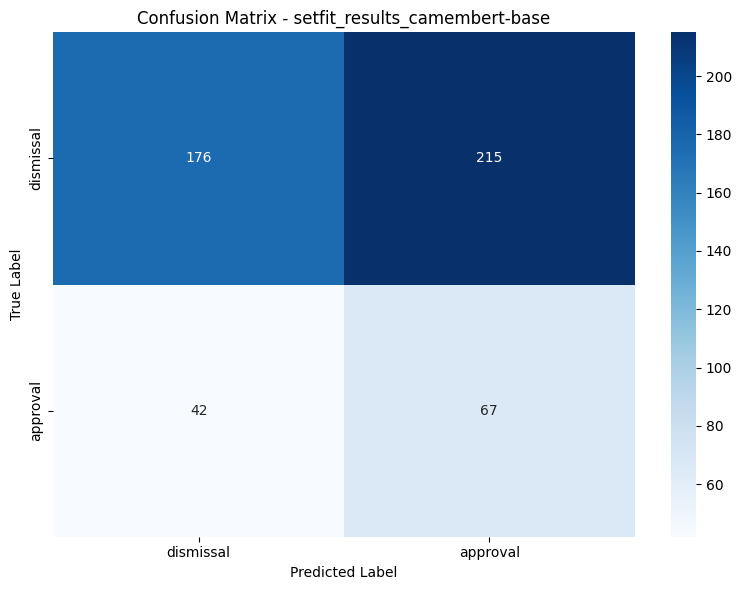

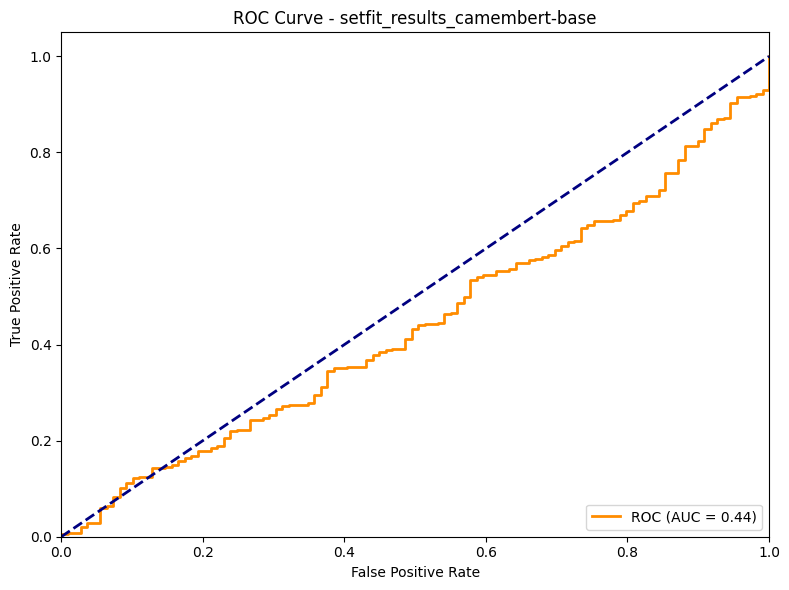

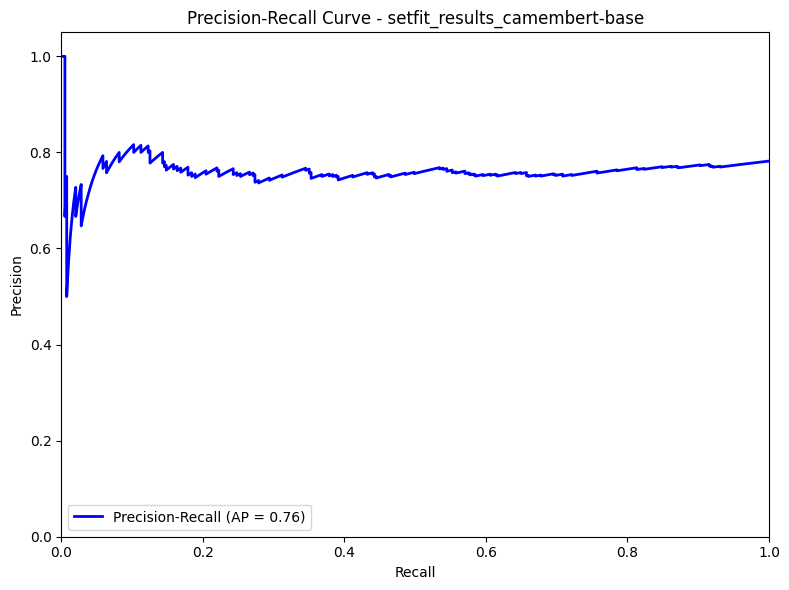

In [ ]:
if 'labels' in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with SetFit

# Evaluate CamemBERT model
model_path = os.path.join('models', 'part_2', 'a', 'setfit_best_camembert-base')

y_test_true, y_test_pred_labels, y_test_pred_probas = evaluate_setfit_on_test(
    model_path=model_path, 
    test_df=test_df_fr, 
    sample_size=500,  # Sample size for the test set (optional, can be adjusted)
    seed=seed
)

# Convert integer labels to string labels for better readability
y_test_true_str = [labels_map[label] for label in y_test_true]
y_test_pred_str = [labels_map[label] for label in y_test_pred_labels]

print("\nFirst 10 true and predicted labels:")
print("True labels:", y_test_true_str[:10])  # Display first 10 true labels
print("Predicted labels:", y_test_pred_str[:10])  # Display first 10 predicted labels
print("Predicted probabilities:", y_test_pred_probas[:10].tolist(), '\n')  # Display first 10 predicted probabilities

# Make evaluation with different metrics
setfit_test_results = evaluate_classification(
    y_true=y_test_true_str,
    y_pred=y_test_pred_str,
    base_filename="setfit_results_camembert-base",
    labels=candidate_labels,
    probas=y_test_pred_probas,
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

Model loaded from: models/part_2/a/setfit_best_juribert-base
Making predictions on test set...

First 10 true and predicted labels:
True labels: ['dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal']
Predicted labels: ['dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal']
Predicted probabilities: [0.0007851355832424193, 0.0027032766031455176, 0.8364745607891187, 0.001584487507313795, 0.04609067038174123, 0.008428140010002723, 0.3586430690073332, 0.9829228549889099, 0.0008136889563317162, 0.0016749083397561162] 

              precision    recall  f1-score   support

   dismissal       0.77      0.62      0.69       391
    approval       0.20      0.35      0.26       109

    accuracy                           0.56       500
   macro avg       0.49      0.49      0.47       500
weighted avg       0.65      0.56      0.60       500



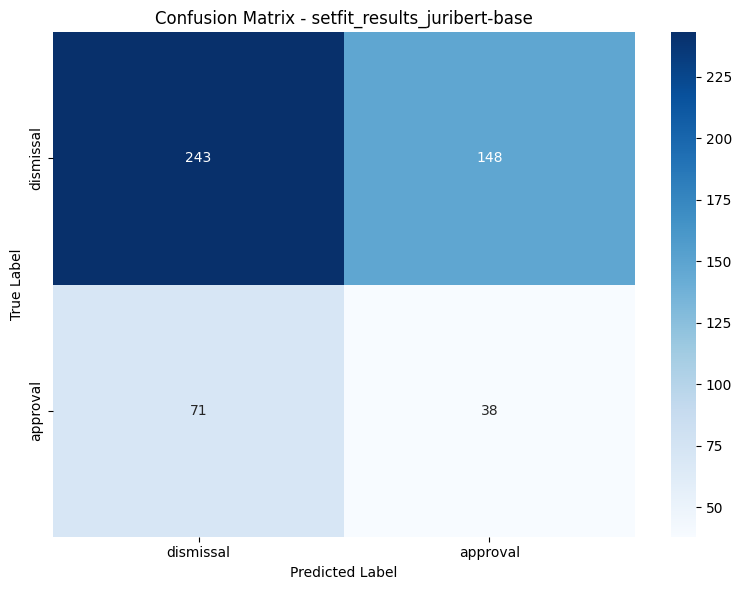

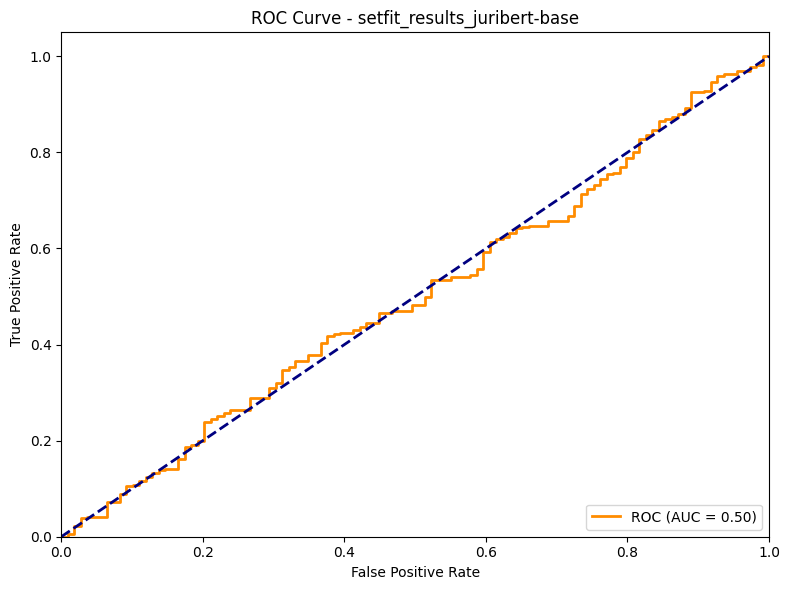

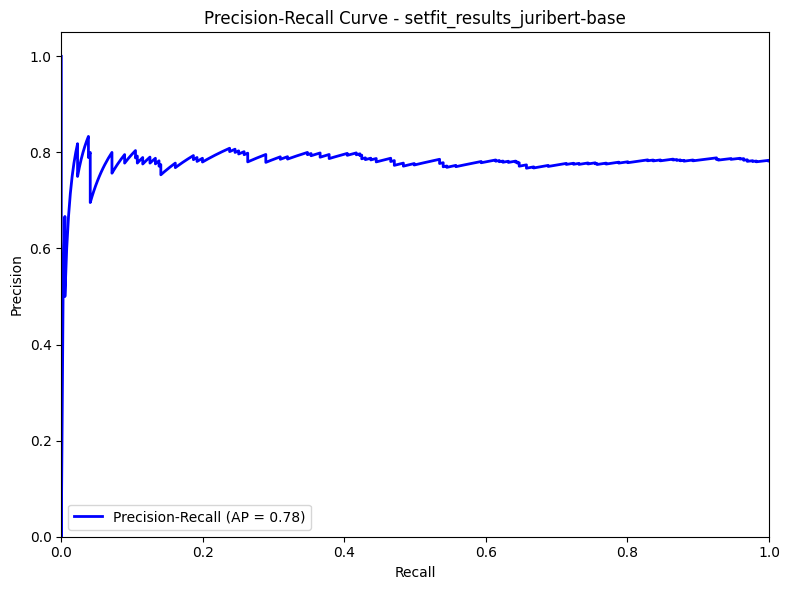

In [ ]:
if 'labels' in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with SetFit

# Evaluate JuriBERT model
model_path = os.path.join('models', 'part_2', 'a', 'setfit_best_juribert-base')

y_test_true, y_test_pred_labels, y_test_pred_probas = evaluate_setfit_on_test(
    model_path=model_path, 
    test_df=test_df_fr, 
    sample_size=500,  # Sample size for the test set (optional, can be adjusted)
    seed=seed
)

# Convert integer labels to string labels for better readability
y_test_true_str = [labels_map[label] for label in y_test_true]
y_test_pred_str = [labels_map[label] for label in y_test_pred_labels]

print("\nFirst 10 true and predicted labels:")
print("True labels:", y_test_true_str[:10])  # Display first 10 true labels
print("Predicted labels:", y_test_pred_str[:10])  # Display first 10 predicted labels
print("Predicted probabilities:", y_test_pred_probas[:10].tolist(), '\n')  # Display first 10 predicted probabilities

# Make evaluation with different metrics
setfit_test_results = evaluate_classification(
    y_true=y_test_true_str,
    y_pred=y_test_pred_str,
    base_filename="setfit_results_juribert-base",
    labels=candidate_labels,
    probas=y_test_pred_probas,
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

### Models with standard fine-tuning

Loading model from: models/part_2/a/cls_fine_tuning_camembert-base/checkpoint-10
Loading tokenizer from: almanach/camembert-base
Sampling 500 rows from the test set...


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Making predictions on the test set...



Evaluating fine-tuned almanach/camembert-base on the test set:
              precision    recall  f1-score   support

   dismissal       0.80      0.66      0.72       373
    approval       0.33      0.50      0.40       127

    accuracy                           0.62       500
   macro avg       0.56      0.58      0.56       500
weighted avg       0.68      0.62      0.64       500



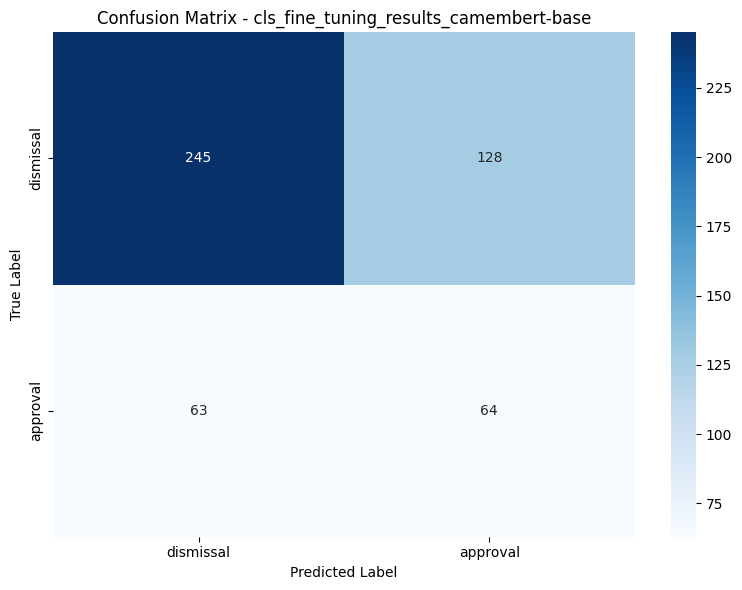

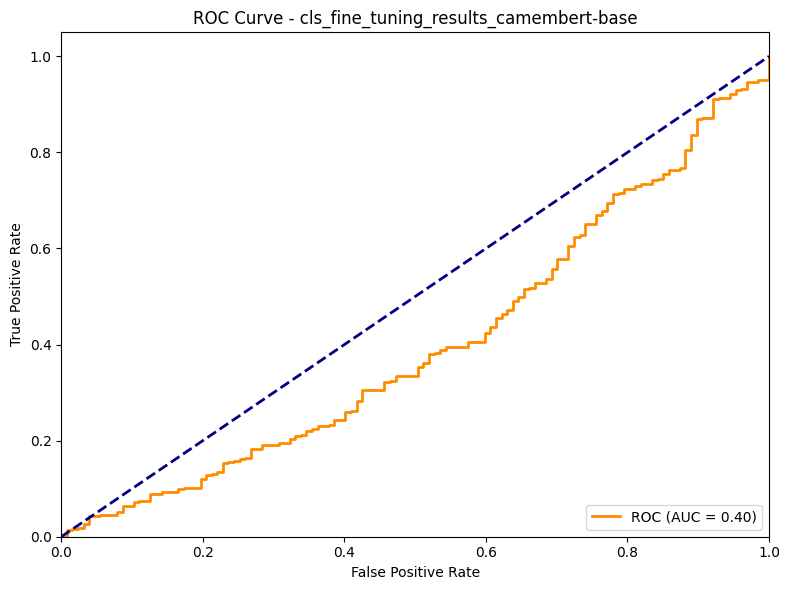

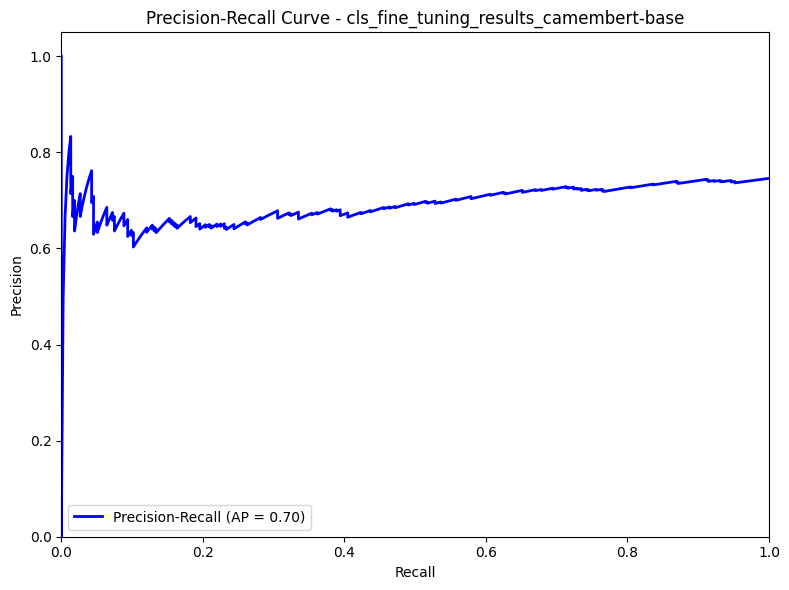

In [6]:
# Evaluate the best fine-tuned model with CamemBERT
max_length = 512  # Maximum length used in training (can be adjusted based on the model)
model_name = "almanach/camembert-base"  # Original model name for tokenizer
sample_size = 500  # Sample size for the test set (optional, can be adjusted)

# First, we determine the best checkpoint directory based on the training results
# (see above)
checkpoint = 10
best_checkpoint_directory = os.path.join('models', 'part_2', 'a', 'cls_fine_tuning_camembert-base', f'checkpoint-{checkpoint}')

# Ensure test_df_fr has 'labels' column, not 'label'
if 'label' in test_df_fr.columns and 'labels' not in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'label': 'labels'})
    
y_true_test, y_pred_test, ft_probas = evaluate_best_finetuned_model(
    test_df=test_df_fr, # Your Polars test DataFrame
    model_checkpoint_path=best_checkpoint_directory, # Path to the best checkpoint
    original_model_name=model_name, # Original model name for tokenizer
    max_length=max_length, # Max length used in training
    sample_size=sample_size, # Sample size for the test set (optional, can be adjusted)
    seed=seed  # Random seed for reproducibility
)

y_true_test_str = [labels_map[label] for label in y_true_test] # Ensure lengths match if test_df_fr_eval was sampled
y_pred_test_str = [labels_map[label] for label in y_pred_test]

print(f"\nEvaluating fine-tuned {model_name} on the test set:")
finetuned_results = evaluate_classification(
    y_true=y_true_test_str,
    y_pred=y_pred_test_str,
    base_filename=f"cls_fine_tuning_results_camembert-base",
    labels=candidate_labels,
    probas=ft_probas, # Probabilities for the positive class
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

Loading model from: models/part_2/a/cls_fine_tuning_juribert-base/checkpoint-4
Loading tokenizer from: dascim/juribert-base
Sampling 500 rows from the test set...


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Making predictions on the test set...



Evaluating fine-tuned dascim/juribert-base on the test set:
              precision    recall  f1-score   support

   dismissal       0.80      0.80      0.80       391
    approval       0.27      0.27      0.27       109

    accuracy                           0.68       500
   macro avg       0.53      0.53      0.53       500
weighted avg       0.68      0.68      0.68       500



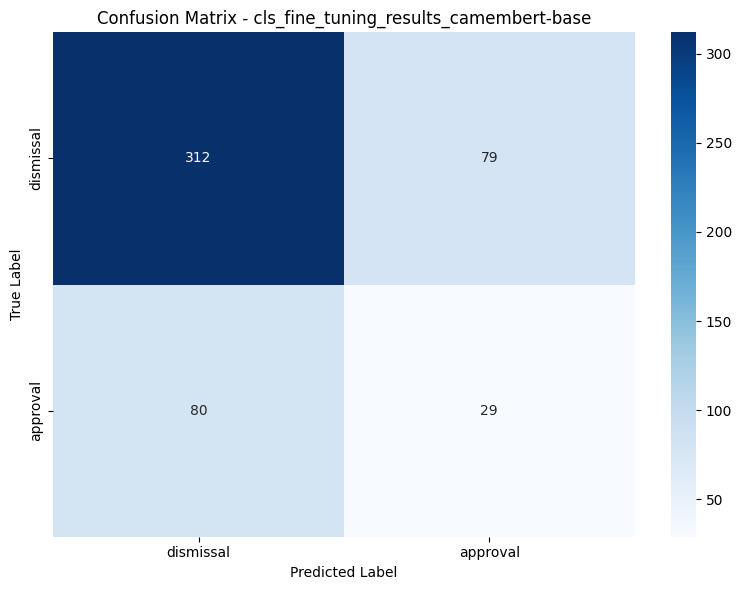

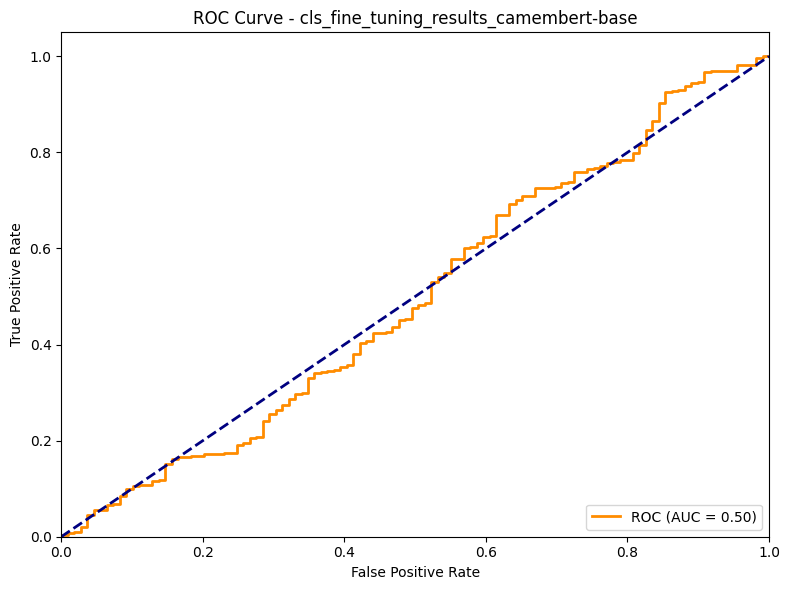

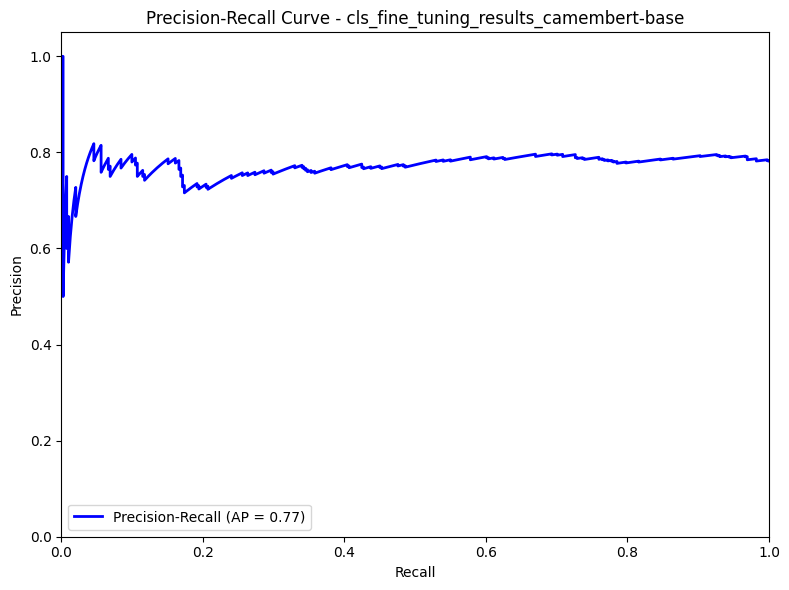

In [10]:
# Evaluate the best fine-tuned model with CamemBERT
max_length = 512  # Maximum length used in training (can be adjusted based on the model)
model_name = "dascim/juribert-base"  # Original model name for tokenizer
sample_size = 500  # Sample size for the test set (optional, can be adjusted)

# First, we determine the best checkpoint directory based on the training results
# (see above)
checkpoint = 4
best_checkpoint_directory = os.path.join('models', 'part_2', 'a', 'cls_fine_tuning_juribert-base', f'checkpoint-{checkpoint}')

# Ensure test_df_fr has 'labels' column, not 'label'
if 'label' in test_df_fr.columns and 'labels' not in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'label': 'labels'})
    
y_true_test, y_pred_test, ft_probas = evaluate_best_finetuned_model(
    test_df=test_df_fr, # Your Polars test DataFrame
    model_checkpoint_path=best_checkpoint_directory, # Path to the best checkpoint
    original_model_name=model_name, # Original model name for tokenizer
    max_length=max_length, # Max length used in training
    sample_size=sample_size, # Sample size for the test set (optional, can be adjusted)
    seed=seed  # Random seed for reproducibility
)

y_true_test_str = [labels_map[label] for label in y_true_test] # Ensure lengths match if test_df_fr_eval was sampled
y_pred_test_str = [labels_map[label] for label in y_pred_test]

print(f"\nEvaluating fine-tuned {model_name} on the test set:")
finetuned_results = evaluate_classification(
    y_true=y_true_test_str,
    y_pred=y_pred_test_str,
    base_filename=f"cls_fine_tuning_results_camembert-base",
    labels=candidate_labels,
    probas=ft_probas, # Probabilities for the positive class
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

## 1.4. Flipping the predictions of CamemBERT base

In [ ]:
if 'labels' in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with SetFit

# Evaluate CamemBERT model
model_path = os.path.join('models', 'part_2', 'a', 'setfit_best_camembert-base')

y_test_true, y_test_pred_labels, y_test_pred_probas = evaluate_setfit_on_test(
    model_path=model_path, 
    test_df=test_df_fr, 
    sample_size=500,  # Sample size for the test set (optional, can be adjusted)
    seed=seed
)

# Convert integer labels to string labels for better readability
y_test_true_str = [labels_map[label] for label in y_test_true]
y_test_pred_str = [labels_map[label] for label in y_test_pred_labels]

print("\nFirst 10 true and predicted labels:")
print("True labels:", y_test_true_str[:10])  # Display first 10 true labels
print("Predicted labels:", y_test_pred_str[:10])  # Display first 10 predicted labels
print("Predicted probabilities:", y_test_pred_probas[:10].tolist(), '\n')  # Display first 10 predicted probabilities

# Make evaluation with different metrics
setfit_test_results = evaluate_classification(
    y_true=y_test_true_str,
    y_pred=y_test_pred_str,
    base_filename="setfit_results_camembert-base",
    labels=candidate_labels,
    probas=y_test_pred_probas,
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

In [ ]:
# Evaluate the best fine-tuned model with CamemBERT
max_length = 512  # Maximum length used in training (can be adjusted based on the model)
model_name = "almanach/camembert-base"  # Original model name for tokenizer
sample_size = 500  # Sample size for the test set (optional, can be adjusted)

# First, we determine the best checkpoint directory based on the training results
# (see above)
checkpoint = 10
best_checkpoint_directory = os.path.join('models', 'part_2', 'a', 'cls_fine_tuning_camembert-base', f'checkpoint-{checkpoint}')

# Ensure test_df_fr has 'labels' column, not 'label'
if 'label' in test_df_fr.columns and 'labels' not in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'label': 'labels'})
    
y_true_test, y_pred_test, ft_probas = evaluate_best_finetuned_model(
    test_df=test_df_fr, # Your Polars test DataFrame
    model_checkpoint_path=best_checkpoint_directory, # Path to the best checkpoint
    original_model_name=model_name, # Original model name for tokenizer
    max_length=max_length, # Max length used in training
    sample_size=sample_size, # Sample size for the test set (optional, can be adjusted)
    seed=seed  # Random seed for reproducibility
)

y_true_test_str = [labels_map[label] for label in y_true_test] # Ensure lengths match if test_df_fr_eval was sampled
y_pred_test_str = [labels_map[label] for label in y_pred_test]

print(f"\nEvaluating fine-tuned {model_name} on the test set:")
finetuned_results = evaluate_classification(
    y_true=y_true_test_str,
    y_pred=y_pred_test_str,
    base_filename=f"cls_fine_tuning_results_camembert-base",
    labels=candidate_labels,
    probas=ft_probas, # Probabilities for the positive class
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

## 1.5. Conclusions

# 2. Dataset Augmentation

The purpose of data augmentation techniques in Natural Language Processing (NLP) is to artificially increase the size and diversity of a training dataset by generating new examples from the existing ones. This helps improve the performance, generalization, and robustness of NLP models, especially when the available labeled data is limited or imbalanced. It also **improves model generalization and avoids overfitting** (by adding noise into the source texts).

**Outline of the intermediate tasks**:
1. Choose Technique(s)
   - Easy Data Augmentation techniques (random insertion, deletion, swap).
   - Random synonym substitution (WordNet or fastText).
   - Back-translation: FR → EN → FR using MarianMT or opus-MT.
2. Implement & Generate
   - For each of the 32 labeled examples for the training data, generate k augmented pseudo-examples (e.g. k=5).
   - Deduplicate and filter (e.g. reject if new text <50% overlap).
3. Merge & Re-split: combine original 32 + synthetic N = 32×k examples.
4. Re-train BERT
   - Exactly the same hyperparams as in (a).
   - Track performance uplift vs. the baseline.
5. Analysis
   - Compare metrics: ΔAccuracy, ΔF1.
   - Ablation: EDA vs. back-translation vs. combined.
   - Qualitative: inspect a few synthetic samples.

We will start by testing each of the data augmentation technique individually, and then combine the ones which provide the best results. On the other hand, we will test the performance of the techniques with the base CamemBERT model.

> Note that data augmentation is ONLY applied to the training data. Neither the validation nor the test sets are augmented with the designed techniques.

## 2.1. Easy Data Augmentation techniques

### Random insertion

#### Example

In [6]:
# First, extract the vocabulary from the training DataFrame
french_vocab_legal = extract_vocabulary(train_df_fr)
print(f"Extracted {len(french_vocab_legal)} unique words from French texts (training set)")

# Sample some words from the vocabulary
print("Sample words:", french_vocab_legal[:10])

Extracted 59830 unique words from French texts (training set)
Sample words: ['péridurale', 'euphoriques', 'créditant', 'orthodontique', 'objectivation', 'donn', 'illégalité', 'cochonneries', 'ramonages', 'précipitamment']


In [7]:
# Create sample text for demonstration
sample_text = train_df_fr['text'][0]  # Get the first text from the training DataFrame

# Initialize the RandomInsertion class with the extracted vocabulary
random_insertion = RandomInsertion(
    ext_vocab=french_vocab_legal,  # Use the extracted French vocabulary
    n=20,  # Number of words to insert
    use_ext_prob=0.5  # Probability of using external vocabulary
)

# Run the RandomInsertion on the sample text
inserted_text = random_insertion.run(sample_text)
  
print("\nOriginal text:")
print(sample_text)
print("\nText after random word insertion:")
print(inserted_text)


Original text:
Faits : A. Dans le cadre d'une enquête menée contre A._, l'Administration fédérale des contributions (AFC), a procédé au mois de juin 2015 à une perquisition, notamment au domicile de A._ à Genève. Elle a saisi un fichier intitulé "Disposizioni testamentarie" et a refusé, par décision du 16 octobre 2018, de retirer ce document du dossier en considérant qu'il n'était pas couvert par le secret professionnel. Par décision du 26 février 2019, la Cour des plaintes du Tribunal fédéral a admis la plainte formée par A._ et a ordonné la restitution du document litigieux. Ce dernier était identique au document déposé et également saisi chez notaire, et qui était protégé par le secret professionnel en vertu d'une décision de la même cour du 12 décembre 2016. Par arrêt du 25 juillet 2019 (1B_158/2019), le Tribunal fédéral a admis un recours formé par l'AFC: le testament original avait été simplement déposé auprès du notaire, sans que celui-ci n'ait participé à son élaboration ni do

We have also developed a function that can take as input the different augmentation techniques shown in this notebook, and implement them sequentially for the input dataset. This function will be used internally in the `run_setfit_training` routine to augment the dataset.

In [ ]:
# Initialize the RandomInsertion class with the extracted vocabulary
random_insertion = RandomInsertion(
    ext_vocab=french_vocab_legal,  # Use the extracted French vocabulary
    n=20,  # Number of words to insert per text
    use_ext_prob=0.5  # Probability of using external vocabulary
)

# Initialize the RandomDeletion class
random_deletion = RandomDeletion(
    p=0.2,  # Probability of deleting each word
    seed=seed  # Random seed for reproducibility
)

# Create a sample Dataset from the training DataFrame
train_df_fr_sample = train_df_fr.sample(n=6, shuffle=True, seed=seed)  # Sample a small subset for demonstration
if 'labels' in train_df_fr_sample.columns:
    train_df_fr_sample = train_df_fr_sample.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with SetFit
train_set_fr = Dataset.from_polars(train_df_fr_sample.select(['text', 'label']))

augmented_dataset = augment_dataset(
    dataset=train_set_fr, 
    techniques=[random_insertion, random_deletion],  # List of augmentation techniques to apply
    augmentation_rate=0.5,  # Rate of augmentations to apply (50% of the dataset - with 6 samples, this means 3 augmented samples per augmentation technique)
    seed=seed  # Random seed for reproducibility
)

# Print the text and the label of the original and augmented dataset
print("\nOriginal training set:")
print("Number of examples:", len(train_set_fr))
for example in train_set_fr:
    print(f"Text: {example['text']}, Label: {example['label']}")
print("\nAugmented training set:")
print("Number of examples:", len(augmented_dataset))
for example in augmented_dataset:
    print(f"Text: {example['text']}, Label: {example['label']}")

Original dataset size: 6
Augmented dataset size: 12
Number of examples added: 6

Original training set:
Number of examples: 6
Text: Faits : A. Par jugement du 24 janvier 2019, le Tribunal criminel de l'arrondissement de la Broye et du Nord Vaudois a constaté que A._ s'est rendue coupable de blanchiment d'argent qualifié et d'infraction grave à la loi fédérale sur les stupéfiants (LStup; RS 812.121) et l'a condamnée à une peine privative de liberté de six ans ainsi qu'à une peine pécuniaire de 180 jours-amende à 30 fr. le jour. Le tribunal a en outre ordonné son expulsion du territoire suisse pour une durée de quinze ans. B. Par jugement du 3 juin 2019, la Cour d'appel pénale du Tribunal cantonal du canton de Vaud a rejeté l'appel formé par le Ministère public vaudois contre le jugement du 24 janvier 2019 et l'appel joint formé par A._. En substance, la cour cantonale a retenu les faits suivants: B.a. A._ est une ressortissante allemande née en 1979. Après sa scolarité obligatoire et le

#### Implementation

In [6]:
# --- 1. Dataset Preparation ---

# Rename columns to match SetFit requirements (labels should be 'label'), creating a copy
train_df_fr_setfit = train_df_fr.clone()
val_df_fr_setfit = val_df_fr.clone()

if 'labels' in train_df_fr_setfit.columns:
    train_df_fr_setfit = train_df_fr_setfit.rename({'labels': 'label'})
if 'labels' in val_df_fr_setfit.columns:
    val_df_fr_setfit = val_df_fr_setfit.rename({'labels': 'label'})

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_fr_setfit = val_df_fr_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

# --- 2. SetFit Training hyperparameters ---

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "almanach/camembert-base"  # Path to the pre-trained model
batch_size = 8  # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training in each iteration
learning_rate= 2e-5  # Learning rate for the optimizer

# --- 3. Configure the data augmentation techniques ---

augmentation_technique_name = 'random_insertion'

# First, extract the vocabulary from the training DataFrame
french_vocab_legal = extract_vocabulary(train_df_fr)
print(f"Extracted {len(french_vocab_legal)} unique words from French texts (training set)")

# Initialize the RandomInsertion class with the extracted vocabulary
da_technique = RandomInsertion(
    ext_vocab=french_vocab_legal,  # Use the extracted French vocabulary
    n=20,  # Number of words to insert per text
    use_ext_prob=0.5  # Probability of using external vocabulary
)

augmentation_techniques = [da_technique]  # List of augmentation techniques to apply

# --- 4. Run SetFit training with data augmentation ---

results_insertion = run_setfit_training(
    train_df=train_df_fr_setfit, 
    val_df=val_df_fr_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed,
    sample_proportion=0.5, # Proportion of positive samples to include in the labelled set (x% of the samples will be positive)
    augmentation_rate=0.5,  # Rate of augmentations to apply (50% of the dataset - with 32 samples, this means 16 augmented samples per augmentation technique)
    augmentation_techniques=augmentation_techniques,  # List of augmentation techniques to apply
    output_path=os.path.join('part_2', 'b'),
    custom_model_name_suffix=augmentation_technique_name  # Suffix for the model name to distinguish it from the base model
)

Extracted 59830 unique words from French texts (training set)

Iteration 1/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.229100
50,0.384700
100,0.267300
150,0.058500
200,0.004800
250,0.002800
300,0.001500
350,0.001500
400,0.001200
450,0.000900


Training completed.
Validation F1: 0.3266
New best model found with f1: 0.3266

Iteration 2/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1208
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.217000
50,0.381200
100,0.260000
150,0.043400
200,0.002400
250,0.001200
300,0.001100
350,0.000900
400,0.000600
450,0.000700


Training completed.
Validation F1: 0.3827
New best model found with f1: 0.3827

Iteration 3/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.229800
50,0.373800
100,0.109400
150,0.004500
200,0.001900
250,0.001400
300,0.003100
350,0.001100
400,0.000800
450,0.000600


Training completed.
Validation F1: 0.3917
New best model found with f1: 0.3917

Iteration 4/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.235300
50,0.382000
100,0.260300
150,0.088200
200,0.002100
250,0.000700
300,0.000500
350,0.000400
400,0.000300
450,0.000300


Training completed.
Validation F1: 0.3876

Iteration 5/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.222000
50,0.370700
100,0.163300
150,0.009200
200,0.002800
250,0.001600
300,0.001100
350,0.001000
400,0.000800
450,0.000900


Training completed.
Validation F1: 0.3920
New best model found with f1: 0.3920
Finished training in all iterations. Saving the results to a parquet file...
Best model saved to: models/part_2/b/setfit_best_camembert-base_random_insertion
Results saved to: results/part_2/b/setfit_results_camembert-base_random_insertion.parquet


In [7]:
model_name = 'camembert-base'
augmentation_technique_name = 'random_insertion'

results = pl.read_parquet(os.path.join('results', 'part_2', 'b', f'setfit_results_{model_name}_{augmentation_technique_name}.parquet'))

print(f'Results for model: {model_name}')
display(results)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results.filter(pl.col('f1') == results['f1'].max())
print("\nBest iteration metrics (highest F1-score):")
display(best_epoch)

Results for model: camembert-base


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.398,0.326622,0.221212,0.623932,1
0.6,0.382716,0.299517,0.529915,2
0.416,0.391667,0.258953,0.803419,3
0.488,0.38756,0.269103,0.692308,4
0.516,0.39196,0.27758,0.666667,5



Best iteration metrics (highest F1-score):


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.516,0.39196,0.27758,0.666667,5


Model loaded from: models/part_2/b/setfit_best_camembert-base_random_insertion
Making predictions on test set...

First 10 true and predicted labels:
True labels: ['dismissal', 'approval', 'approval', 'dismissal', 'dismissal', 'dismissal', 'approval', 'dismissal', 'approval', 'dismissal']
Predicted labels: ['approval', 'approval', 'dismissal', 'approval', 'dismissal', 'approval', 'approval', 'approval', 'approval', 'approval']
Predicted probabilities: [0.8336134788020468, 0.8764316373186973, 0.40526826723388437, 0.9814619938783944, 0.06938647168591888, 0.943552110011207, 0.9889043465979684, 0.9525918436099307, 0.6904719497726112, 0.9320642297997284] 

              precision    recall  f1-score   support

   dismissal       0.80      0.45      0.57       373
    approval       0.29      0.67      0.41       127

    accuracy                           0.50       500
   macro avg       0.55      0.56      0.49       500
weighted avg       0.67      0.50      0.53       500



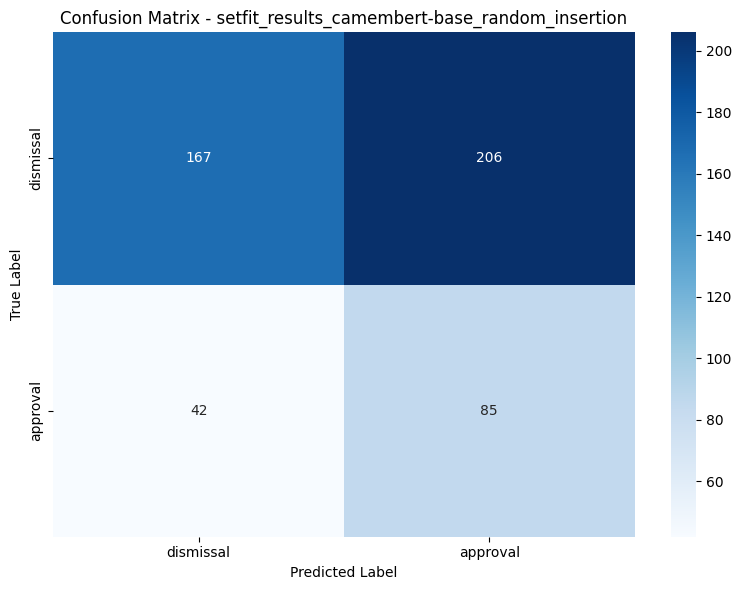

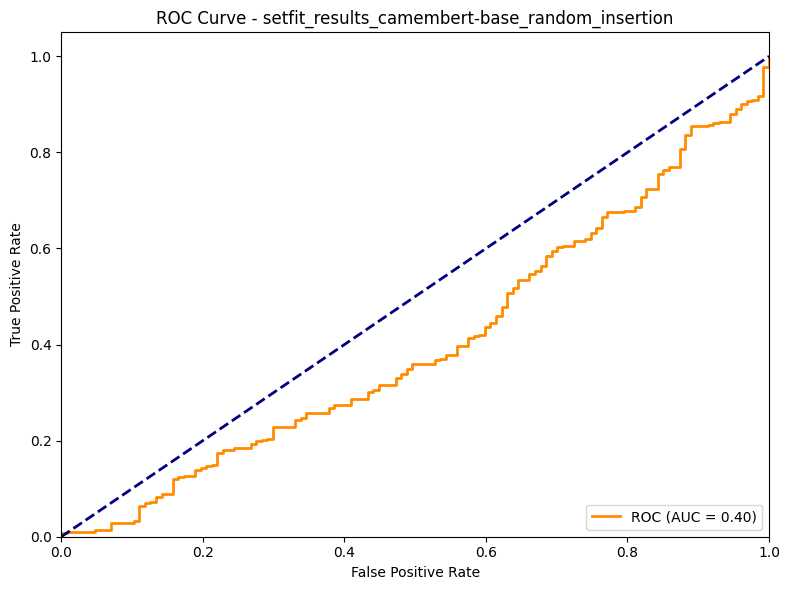

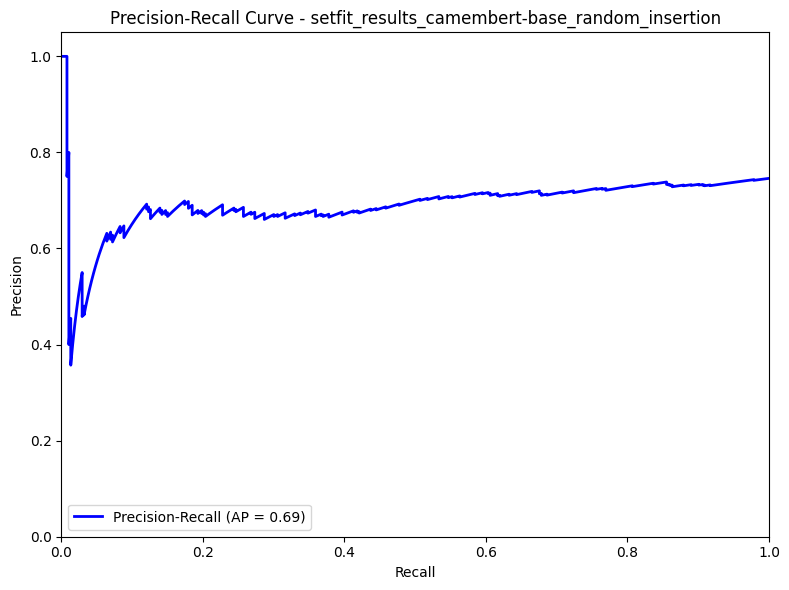

In [8]:
model_name = 'camembert-base'
augmentation_technique_name = 'random_insertion'


# Evaluate CamemBERT model
if 'labels' in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with SetFit

model_path = os.path.join('models', 'part_2', 'b', f'setfit_best_{model_name}_{augmentation_technique_name}')

y_test_true, y_test_pred_labels, y_test_pred_probas = evaluate_setfit_on_test(
    model_path=model_path, 
    test_df=test_df_fr, 
    sample_size=500,  # Sample size for the test set (optional, can be adjusted)
    seed=seed
)

# Convert integer labels to string labels for better readability
y_test_true_str = [labels_map[label] for label in y_test_true]
y_test_pred_str = [labels_map[label] for label in y_test_pred_labels]

print("\nFirst 10 true and predicted labels:")
print("True labels:", y_test_true_str[:10])  # Display first 10 true labels
print("Predicted labels:", y_test_pred_str[:10])  # Display first 10 predicted labels
print("Predicted probabilities:", y_test_pred_probas[:10].tolist(), '\n')  # Display first 10 predicted probabilities

# Make evaluation with different metrics
setfit_test_results = evaluate_classification(
    y_true=y_test_true_str,
    y_pred=y_test_pred_str,
    base_filename=f"setfit_results_{model_name}_{augmentation_technique_name}",
    labels=candidate_labels,
    probas=y_test_pred_probas,
    results_dir=os.path.join('results', 'part_2', 'b', 'test')
)

### Random deletion

#### Example

In [9]:
# # Create sample text for demonstration
# sample_text = train_df_fr['text'][0]  # Get the first text from the training DataFrame

# # Initialize the RandomDeletion class
# random_deletion = RandomDeletion(
#     p=0.2,  # Probability of deleting each word
#     seed=seed  # Random seed for reproducibility
# )

# # Apply random deletion to the sample text
# reduced_text = random_deletion.run(sample_text)

# print("\nOriginal text:")
# print(sample_text)
# print("\nText after random word deletion:")
# print(reduced_text)

#### Implementation

In [10]:
# --- 1. Dataset Preparation ---

# Rename columns to match SetFit requirements (labels should be 'label'), creating a copy
train_df_fr_setfit = train_df_fr.clone()
val_df_fr_setfit = val_df_fr.clone()

if 'labels' in train_df_fr_setfit.columns:
    train_df_fr_setfit = train_df_fr_setfit.rename({'labels': 'label'})
if 'labels' in val_df_fr_setfit.columns:
    val_df_fr_setfit = val_df_fr_setfit.rename({'labels': 'label'})

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_fr_setfit = val_df_fr_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

# --- 2. SetFit Training hyperparameters ---

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "almanach/camembert-base"  # Path to the pre-trained model
batch_size = 8  # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training in each iteration
learning_rate= 2e-5  # Learning rate for the optimizer

# --- 3. Configure the data augmentation techniques ---

augmentation_technique_name = 'random_deletion'

# Initialize the technique class
da_technique = RandomDeletion(
    p=0.3,  # Probability of deleting each word
    seed=seed  # Random seed for reproducibility
)

augmentation_techniques = [da_technique]  # List of augmentation techniques to apply

# --- 4. Run SetFit training with data augmentation ---

results_deletion = run_setfit_training(
    train_df=train_df_fr_setfit, 
    val_df=val_df_fr_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed,
    sample_proportion=0.5, # Proportion of positive samples to include in the labelled set (x% of the samples will be positive)
    augmentation_rate=0.5,  # Rate of augmentations to apply (50% of the dataset - with 32 samples, this means 16 augmented samples per augmentation technique)
    augmentation_techniques=augmentation_techniques,  # List of augmentation techniques to apply
    output_path=os.path.join('part_2', 'b'),
    custom_model_name_suffix=augmentation_technique_name  # Suffix for the model name to distinguish it from the base model
)


Iteration 1/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.252700
50,0.371000
100,0.290400
150,0.221900
200,0.018700
250,0.004200
300,0.001800
350,0.001000
400,0.000900
450,0.000600


Training completed.
Validation F1: 0.2899
New best model found with f1: 0.2899

Iteration 2/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1208
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.162200
50,0.365000
100,0.282100
150,0.054300
200,0.003200
250,0.001800
300,0.001100
350,0.001000
400,0.000800
450,0.000800


Training completed.
Validation F1: 0.3448
New best model found with f1: 0.3448

Iteration 3/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.186700
50,0.382400
100,0.199000
150,0.017600
200,0.003000
250,0.002400
300,0.001200
350,0.001200
400,0.000800
450,0.000800


Training completed.
Validation F1: 0.3890
New best model found with f1: 0.3890

Iteration 4/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.245300
50,0.362600
100,0.271300
150,0.135200
200,0.002500
250,0.000800
300,0.000500
350,0.000400
400,0.000200
450,0.000200


Training completed.
Validation F1: 0.3929
New best model found with f1: 0.3929

Iteration 5/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.205700
50,0.370200
100,0.195800
150,0.013000
200,0.003800
250,0.001500
300,0.001200
350,0.001000
400,0.000800
450,0.000800


Training completed.
Validation F1: 0.3814
Finished training in all iterations. Saving the results to a parquet file...
Best model saved to: models/part_2/b/setfit_best_camembert-base_random_deletion
Results saved to: results/part_2/b/setfit_results_camembert-base_random_deletion.parquet


In [11]:
model_name = 'camembert-base'
augmentation_technique_name = 'random_deletion'

results = pl.read_parquet(os.path.join('results', 'part_2', 'b', f'setfit_results_{model_name}_{augmentation_technique_name}.parquet'))

print(f'Results for model: {model_name}')
display(results)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results.filter(pl.col('f1') == results['f1'].max())
print("\nBest iteration metrics (highest F1-score):")
display(best_epoch)

Results for model: camembert-base


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.51,0.289855,0.219298,0.42735,1
0.62,0.344828,0.289017,0.42735,2
0.422,0.389006,0.258427,0.786325,3
0.518,0.392947,0.278571,0.666667,4
0.52,0.381443,0.273063,0.632479,5



Best iteration metrics (highest F1-score):


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.518,0.392947,0.278571,0.666667,4


Model loaded from: models/part_2/b/setfit_best_camembert-base_random_deletion
Making predictions on test set...

First 10 true and predicted labels:
True labels: ['dismissal', 'approval', 'approval', 'dismissal', 'dismissal', 'dismissal', 'approval', 'dismissal', 'approval', 'dismissal']
Predicted labels: ['dismissal', 'approval', 'approval', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval']
Predicted probabilities: [0.012590596093444968, 0.9699475985728707, 0.9916668587813893, 0.9913481035604438, 0.01115627643750517, 0.18495871392171845, 0.9637781961481356, 0.016426770783407676, 0.14363499562328508, 0.9892243008788233] 

              precision    recall  f1-score   support

   dismissal       0.79      0.49      0.61       373
    approval       0.29      0.61      0.40       127

    accuracy                           0.52       500
   macro avg       0.54      0.55      0.50       500
weighted avg       0.66      0.52      0.55       500



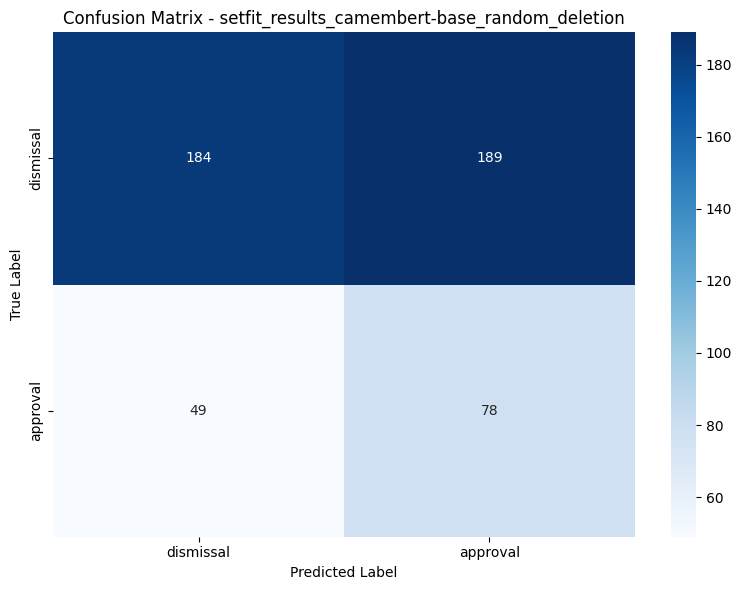

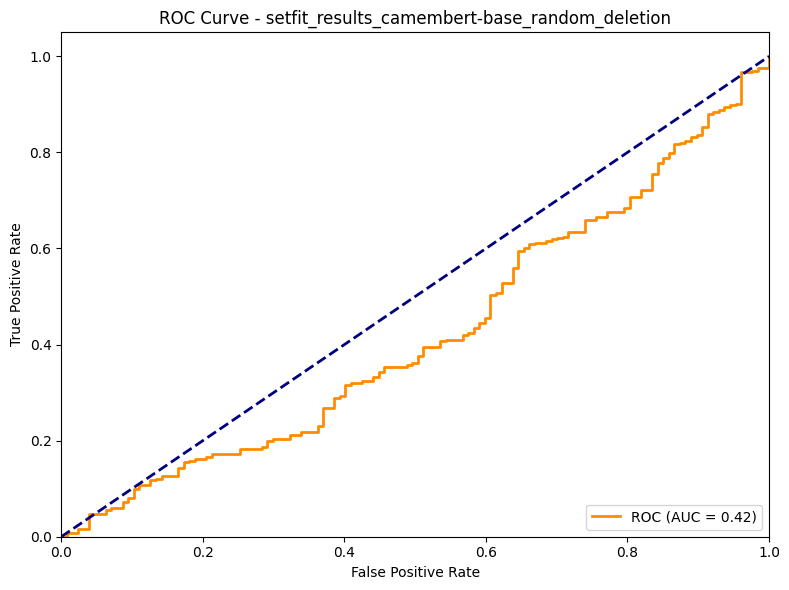

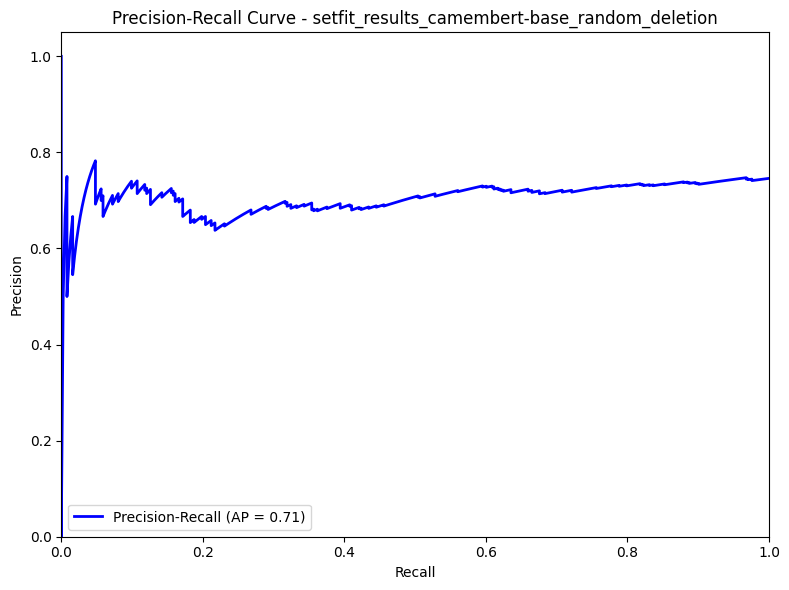

In [12]:
model_name = 'camembert-base'
augmentation_technique_name = 'random_deletion'

# Evaluate CamemBERT model
if 'labels' in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with SetFit

model_path = os.path.join('models', 'part_2', 'b', f'setfit_best_{model_name}_{augmentation_technique_name}')

y_test_true, y_test_pred_labels, y_test_pred_probas = evaluate_setfit_on_test(
    model_path=model_path, 
    test_df=test_df_fr, 
    sample_size=500,  # Sample size for the test set (optional, can be adjusted)
    seed=seed
)

# Convert integer labels to string labels for better readability
y_test_true_str = [labels_map[label] for label in y_test_true]
y_test_pred_str = [labels_map[label] for label in y_test_pred_labels]

print("\nFirst 10 true and predicted labels:")
print("True labels:", y_test_true_str[:10])  # Display first 10 true labels
print("Predicted labels:", y_test_pred_str[:10])  # Display first 10 predicted labels
print("Predicted probabilities:", y_test_pred_probas[:10].tolist(), '\n')  # Display first 10 predicted probabilities

# Make evaluation with different metrics
setfit_test_results = evaluate_classification(
    y_true=y_test_true_str,
    y_pred=y_test_pred_str,
    base_filename=f"setfit_results_{model_name}_{augmentation_technique_name}",
    labels=candidate_labels,
    probas=y_test_pred_probas,
    results_dir=os.path.join('results', 'part_2', 'b', 'test')
)

### Random swap

#### Example

In [13]:
# # Create sample text for demonstration
# sample_text = train_df_fr['text'][0]  # Get the first text from the training DataFrame

# # Initialize the RandomSwap class
# random_swap = RandomSwap(
#     n=20,  # Number of pairs of words to swap
#     seed=seed  # Random seed for reproducibility
# )

# # Run the random swap on the sample text
# swapped_text = random_swap.run(sample_text)

# print("\nOriginal text:")
# print(sample_text)
# print("\nText after random swap:")
# print(swapped_text)

#### Implementation

In [14]:
# --- 1. Dataset Preparation ---

# Rename columns to match SetFit requirements (labels should be 'label'), creating a copy
train_df_fr_setfit = train_df_fr.clone()
val_df_fr_setfit = val_df_fr.clone()

if 'labels' in train_df_fr_setfit.columns:
    train_df_fr_setfit = train_df_fr_setfit.rename({'labels': 'label'})
if 'labels' in val_df_fr_setfit.columns:
    val_df_fr_setfit = val_df_fr_setfit.rename({'labels': 'label'})

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_fr_setfit = val_df_fr_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

# --- 2. SetFit Training hyperparameters ---

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "almanach/camembert-base"  # Path to the pre-trained model
batch_size = 8  # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training in each iteration
learning_rate= 2e-5  # Learning rate for the optimizer

# --- 3. Configure the data augmentation techniques ---

augmentation_technique_name = 'random_swap'

# Initialize the technique class
da_technique = RandomSwap(
    n=30,  # Number of pairs of words to swap per text
    seed=seed  # Random seed for reproducibility
)

augmentation_techniques = [da_technique]  # List of augmentation techniques to apply

# --- 4. Run SetFit training with data augmentation ---

results_deletion = run_setfit_training(
    train_df=train_df_fr_setfit, 
    val_df=val_df_fr_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed,
    sample_proportion=0.5, # Proportion of positive samples to include in the labelled set (x% of the samples will be positive)
    augmentation_rate=0.5,  # Rate of augmentations to apply (50% of the dataset - with 32 samples, this means 16 augmented samples per augmentation technique)
    augmentation_techniques=augmentation_techniques,  # List of augmentation techniques to apply
    output_path=os.path.join('part_2', 'b'),
    custom_model_name_suffix=augmentation_technique_name  # Suffix for the model name to distinguish it from the base model
)


Iteration 1/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.238700
50,0.375800
100,0.290200
150,0.142200
200,0.007000
250,0.004000
300,0.001200
350,0.001200
400,0.000800
450,0.000500


Training completed.
Validation F1: 0.3193
New best model found with f1: 0.3193

Iteration 2/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1208
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.181200
50,0.372300
100,0.275200
150,0.050400
200,0.002700
250,0.001300
300,0.000900
350,0.000800
400,0.000600
450,0.000800


Training completed.
Validation F1: 0.3580
New best model found with f1: 0.3580

Iteration 3/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.201400
50,0.379800
100,0.185800
150,0.013500
200,0.002800
250,0.001600
300,0.001000
350,0.001000
400,0.000900
450,0.000800


Training completed.
Validation F1: 0.3944
New best model found with f1: 0.3944

Iteration 4/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.241500
50,0.369100
100,0.267900
150,0.125700
200,0.002400
250,0.000500
300,0.000400
350,0.000300
400,0.000200
450,0.000200


Training completed.
Validation F1: 0.3942

Iteration 5/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.221300
50,0.373100
100,0.192700
150,0.010800
200,0.002500
250,0.001300
300,0.001200
350,0.000800
400,0.000800
450,0.001000


Training completed.
Validation F1: 0.3840
Finished training in all iterations. Saving the results to a parquet file...
Best model saved to: models/part_2/b/setfit_best_camembert-base_random_swap
Results saved to: results/part_2/b/setfit_results_camembert-base_random_swap.parquet


In [15]:
model_name = 'camembert-base'
augmentation_technique_name = 'random_swap'

results = pl.read_parquet(os.path.join('results', 'part_2', 'b', f'setfit_results_{model_name}_{augmentation_technique_name}.parquet'))

print(f'Results for model: {model_name}')
display(results)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results.filter(pl.col('f1') == results['f1'].max())
print("\nBest iteration metrics (highest F1-score):")
display(best_epoch)

Results for model: camembert-base


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.514,0.319328,0.2375,0.487179,1
0.584,0.358025,0.280193,0.495726,2
0.484,0.394366,0.271845,0.717949,3
0.502,0.394161,0.27551,0.692308,4
0.538,0.384,0.27907,0.615385,5



Best iteration metrics (highest F1-score):


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.484,0.394366,0.271845,0.717949,3


Model loaded from: models/part_2/b/setfit_best_camembert-base_random_swap
Making predictions on test set...

First 10 true and predicted labels:
True labels: ['dismissal', 'approval', 'approval', 'dismissal', 'dismissal', 'dismissal', 'approval', 'dismissal', 'approval', 'dismissal']
Predicted labels: ['approval', 'approval', 'approval', 'approval', 'approval', 'approval', 'approval', 'approval', 'dismissal', 'approval']
Predicted probabilities: [0.8133044267494972, 0.9554896152144876, 0.8683528294989575, 0.98993216795918, 0.7009765036668167, 0.6976310417739057, 0.808220764197414, 0.9184108943488222, 0.24104348992705238, 0.6701664125057557] 

              precision    recall  f1-score   support

   dismissal       0.81      0.37      0.50       373
    approval       0.28      0.74      0.41       127

    accuracy                           0.46       500
   macro avg       0.55      0.55      0.46       500
weighted avg       0.67      0.46      0.48       500



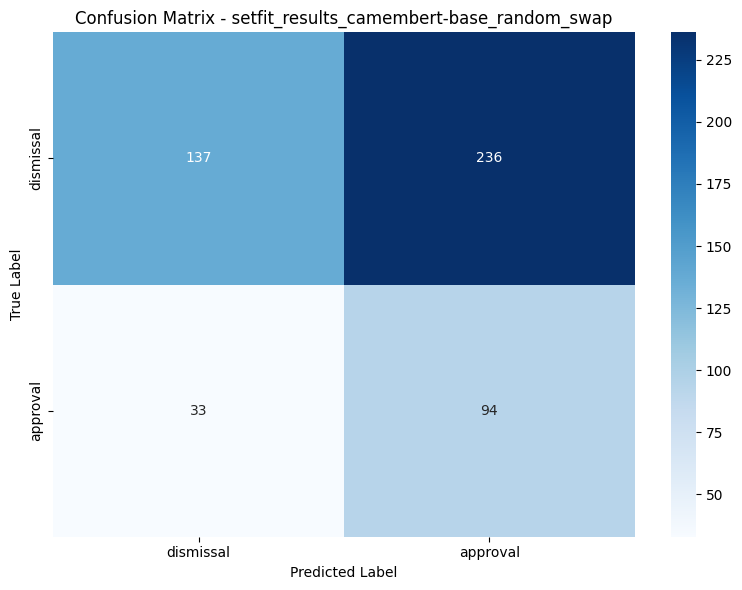

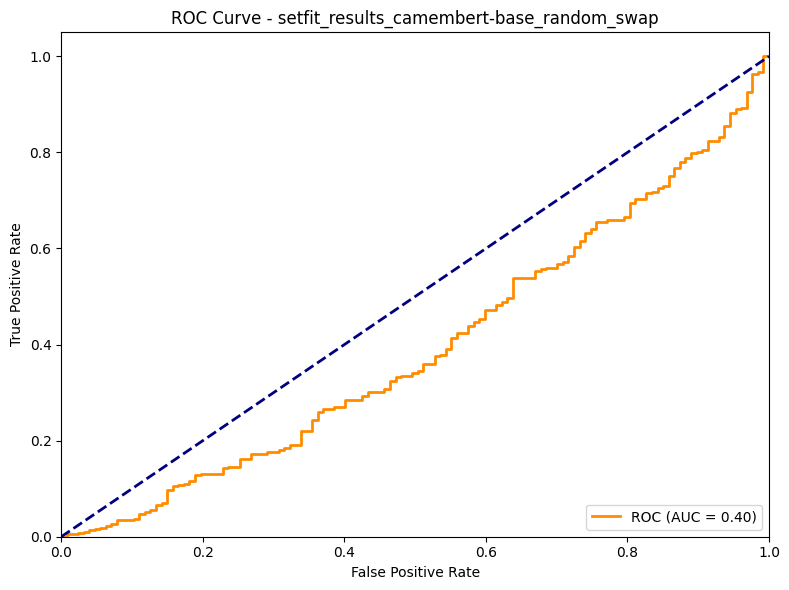

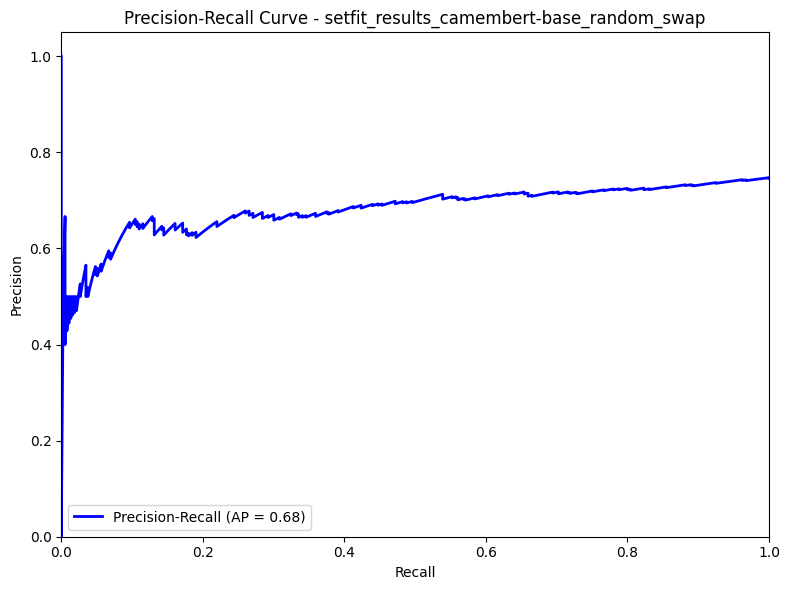

In [16]:
model_name = 'camembert-base'
augmentation_technique_name = 'random_swap'

# Evaluate CamemBERT model
if 'labels' in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with SetFit

model_path = os.path.join('models', 'part_2', 'b', f'setfit_best_{model_name}_{augmentation_technique_name}')

y_test_true, y_test_pred_labels, y_test_pred_probas = evaluate_setfit_on_test(
    model_path=model_path, 
    test_df=test_df_fr, 
    sample_size=500,  # Sample size for the test set (optional, can be adjusted)
    seed=seed
)

# Convert integer labels to string labels for better readability
y_test_true_str = [labels_map[label] for label in y_test_true]
y_test_pred_str = [labels_map[label] for label in y_test_pred_labels]

print("\nFirst 10 true and predicted labels:")
print("True labels:", y_test_true_str[:10])  # Display first 10 true labels
print("Predicted labels:", y_test_pred_str[:10])  # Display first 10 predicted labels
print("Predicted probabilities:", y_test_pred_probas[:10].tolist(), '\n')  # Display first 10 predicted probabilities

# Make evaluation with different metrics
setfit_test_results = evaluate_classification(
    y_true=y_test_true_str,
    y_pred=y_test_pred_str,
    base_filename=f"setfit_results_{model_name}_{augmentation_technique_name}",
    labels=candidate_labels,
    probas=y_test_pred_probas,
    results_dir=os.path.join('results', 'part_2', 'b', 'test')
)

## 2.2. Random Synonym Substitution

#### Example

In [17]:
# synonyms = get_french_synonyms('avocat')  # Example word in French

# print(f"Synonyms for 'avocat': {synonyms}")

Note that some synonym replacements may introduce a lot of noise (which might be beneficial to prevent overfitting, but harmful for specialization in legal texts). In this case, "avocat" (lawyer) can be replaced by the scientific word for "avocado" (persea americana).

In [18]:
# # Create sample text for demonstration
# sample_text = train_df_fr['text'][0]  # Get the first text from the training DataFrame

# # Initialize the SynonymReplacement class
# synonym_replacement = SynonymReplacement(
#     n=50,  # Number of words to replace with synonyms
#     seed=seed,  # Random seed for reproducibility
# )

# # Apply random synonym replacement to the sample text
# synonym_text = synonym_replacement.run(sample_text)

# print("\nOriginal text:")
# print(sample_text)
# print("\nText after random synonym replacement:")
# print(synonym_text)

#### Implementation

In [7]:
# --- 1. Dataset Preparation ---

# Rename columns to match SetFit requirements (labels should be 'label'), creating a copy
train_df_fr_setfit = train_df_fr.clone()
val_df_fr_setfit = val_df_fr.clone()

if 'labels' in train_df_fr_setfit.columns:
    train_df_fr_setfit = train_df_fr_setfit.rename({'labels': 'label'})
if 'labels' in val_df_fr_setfit.columns:
    val_df_fr_setfit = val_df_fr_setfit.rename({'labels': 'label'})

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_fr_setfit = val_df_fr_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

# --- 2. SetFit Training hyperparameters ---

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "almanach/camembert-base"  # Path to the pre-trained model
batch_size = 8  # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training in each iteration
learning_rate= 2e-5  # Learning rate for the optimizer

# --- 3. Configure the data augmentation techniques ---

augmentation_technique_name = 'synonym_replacement'

# Initialize the technique class
da_technique = SynonymReplacement(
    n=40,  # Number of words to replace with synonyms per text
    seed=seed
)

augmentation_techniques = [da_technique]  # List of augmentation techniques to apply

# --- 4. Run SetFit training with data augmentation ---

results_deletion = run_setfit_training(
    train_df=train_df_fr_setfit, 
    val_df=val_df_fr_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed,
    sample_proportion=0.5, # Proportion of positive samples to include in the labelled set (x% of the samples will be positive)
    augmentation_rate=0.5,  # Rate of augmentations to apply (50% of the dataset - with 32 samples, this means 16 augmented samples per augmentation technique)
    augmentation_techniques=augmentation_techniques,  # List of augmentation techniques to apply
    output_path=os.path.join('part_2', 'b'),
    custom_model_name_suffix=augmentation_technique_name  # Suffix for the model name to distinguish it from the base model
)


Iteration 1/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.228600
50,0.384500
100,0.242700
150,0.024400
200,0.004600
250,0.001700
300,0.001200
350,0.001200
400,0.001000
450,0.000700


Training completed.
Validation F1: 0.3182
New best model found with f1: 0.3182

Iteration 2/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1208
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.219000
50,0.382300
100,0.264100
150,0.052200
200,0.002900
250,0.001400
300,0.001000
350,0.000700
400,0.000500
450,0.000600


Training completed.
Validation F1: 0.3821
New best model found with f1: 0.3821

Iteration 3/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.221700
50,0.371300
100,0.074400
150,0.004700
200,0.001800
250,0.001400
300,0.002600
350,0.001400
400,0.000900
450,0.000700


Training completed.
Validation F1: 0.3843
New best model found with f1: 0.3843

Iteration 4/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.235300
50,0.384200
100,0.257800
150,0.078500
200,0.002200
250,0.000700
300,0.000500
350,0.000300
400,0.000300
450,0.000200


Training completed.
Validation F1: 0.3907
New best model found with f1: 0.3907

Iteration 5/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.221900
50,0.370100
100,0.149900
150,0.008800
200,0.002300
250,0.002200
300,0.001500
350,0.001100
400,0.000800
450,0.000700


Training completed.
Validation F1: 0.3817
Finished training in all iterations. Saving the results to a parquet file...
Best model saved to: models/part_2/b/setfit_best_camembert-base_synonym_replacement
Results saved to: results/part_2/b/setfit_results_camembert-base_synonym_replacement.parquet


In [8]:
model_name = 'camembert-base'
augmentation_technique_name = 'synonym_replacement'

results = pl.read_parquet(os.path.join('results', 'part_2', 'b', f'setfit_results_{model_name}_{augmentation_technique_name}.parquet'))

print(f'Results for model: {model_name}')
display(results)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results.filter(pl.col('f1') == results['f1'].max())
print("\nBest iteration metrics (highest F1-score):")
display(best_epoch)

Results for model: camembert-base


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.4,0.318182,0.216718,0.598291,1
0.586,0.38209,0.293578,0.547009,2
0.404,0.384298,0.253406,0.794872,3
0.476,0.390698,0.268371,0.717949,4
0.514,0.381679,0.271739,0.641026,5



Best iteration metrics (highest F1-score):


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.476,0.390698,0.268371,0.717949,4


Model loaded from: models/part_2/b/setfit_best_camembert-base_synonym_replacement
Making predictions on test set...

First 10 true and predicted labels:
True labels: ['dismissal', 'approval', 'approval', 'dismissal', 'dismissal', 'dismissal', 'approval', 'dismissal', 'approval', 'dismissal']
Predicted labels: ['dismissal', 'approval', 'approval', 'approval', 'dismissal', 'approval', 'approval', 'dismissal', 'dismissal', 'approval']
Predicted probabilities: [0.021205339606913762, 0.9816368399940169, 0.9926332200729632, 0.9884858320119569, 0.012412635672680498, 0.8067737753083357, 0.9514795943668702, 0.04196779961513118, 0.22867707023897688, 0.9895987784500061] 

              precision    recall  f1-score   support

   dismissal       0.80      0.44      0.57       373
    approval       0.29      0.69      0.41       127

    accuracy                           0.50       500
   macro avg       0.55      0.56      0.49       500
weighted avg       0.67      0.50      0.53       500



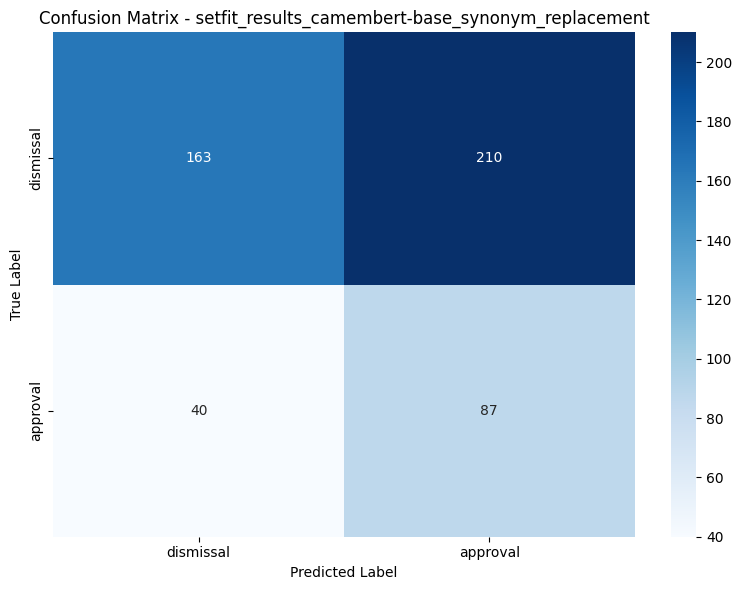

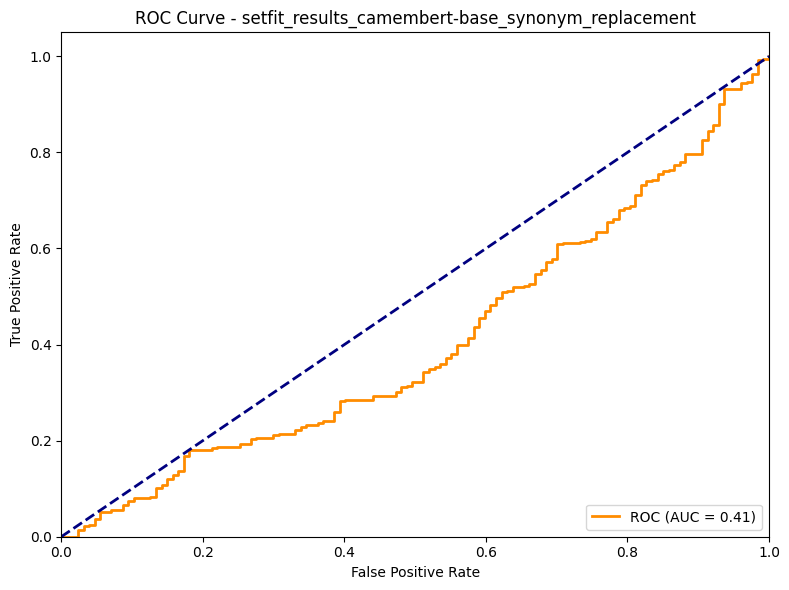

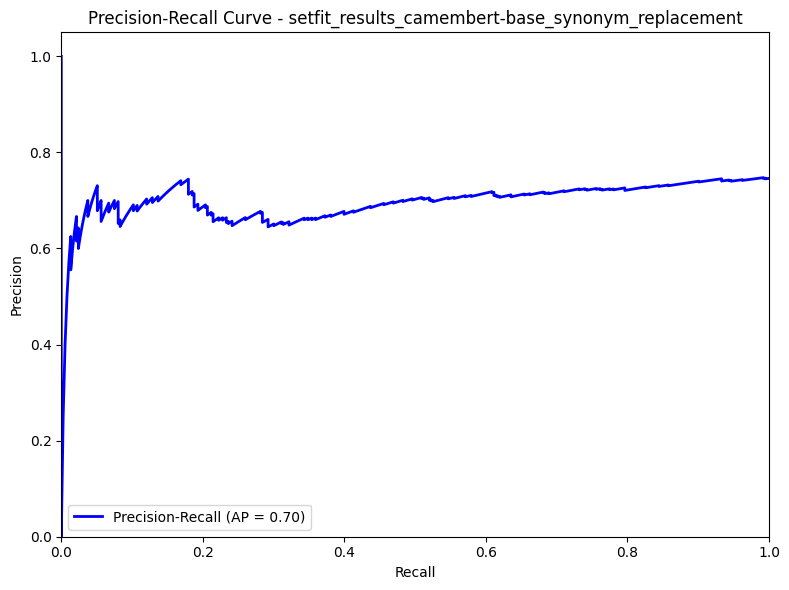

In [9]:
model_name = 'camembert-base'
augmentation_technique_name = 'synonym_replacement'

# Evaluate CamemBERT model
if 'labels' in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with SetFit

model_path = os.path.join('models', 'part_2', 'b', f'setfit_best_{model_name}_{augmentation_technique_name}')

y_test_true, y_test_pred_labels, y_test_pred_probas = evaluate_setfit_on_test(
    model_path=model_path, 
    test_df=test_df_fr, 
    sample_size=500,  # Sample size for the test set (optional, can be adjusted)
    seed=seed
)

# Convert integer labels to string labels for better readability
y_test_true_str = [labels_map[label] for label in y_test_true]
y_test_pred_str = [labels_map[label] for label in y_test_pred_labels]

print("\nFirst 10 true and predicted labels:")
print("True labels:", y_test_true_str[:10])  # Display first 10 true labels
print("Predicted labels:", y_test_pred_str[:10])  # Display first 10 predicted labels
print("Predicted probabilities:", y_test_pred_probas[:10].tolist(), '\n')  # Display first 10 predicted probabilities

# Make evaluation with different metrics
setfit_test_results = evaluate_classification(
    y_true=y_test_true_str,
    y_pred=y_test_pred_str,
    base_filename=f"setfit_results_{model_name}_{augmentation_technique_name}",
    labels=candidate_labels,
    probas=y_test_pred_probas,
    results_dir=os.path.join('results', 'part_2', 'b', 'test')
)

## 2.3. Back Translation

#### Example

In [10]:
# # Test the improved back translator
# translator = BackTranslator(max_length=256)  # Set the maximum length for the text chunks to be back-translated

# # Apply to sample text
# sample_text = train_df_fr['text'][0]  # Get the first text from the training DataFrame
# back_translated = translator.run(sample_text)

# print("Original text length:", len(sample_text.split()))
# print("Original text:", sample_text)

# print("\nBack-translated text length:", len(back_translated.split()))
# print("Back-translated text:", back_translated)

# # Compare lengths and check for repetition issues
# print(f"\nOriginal word count: {len(sample_text.split())}")
# print(f"Back-translated word count: {len(back_translated.split())}")
# print(f"Length ratio: {len(back_translated.split()) / len(sample_text.split()):.2f}")

#### Implementation

In [11]:
# --- 1. Dataset Preparation ---

# Rename columns to match SetFit requirements (labels should be 'label'), creating a copy
train_df_fr_setfit = train_df_fr.clone()
val_df_fr_setfit = val_df_fr.clone()

if 'labels' in train_df_fr_setfit.columns:
    train_df_fr_setfit = train_df_fr_setfit.rename({'labels': 'label'})
if 'labels' in val_df_fr_setfit.columns:
    val_df_fr_setfit = val_df_fr_setfit.rename({'labels': 'label'})

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_fr_setfit = val_df_fr_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

# --- 2. SetFit Training hyperparameters ---

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "almanach/camembert-base"  # Path to the pre-trained model
batch_size = 8  # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training in each iteration
learning_rate= 2e-5  # Learning rate for the optimizer

# --- 3. Configure the data augmentation techniques ---

augmentation_technique_name = 'back_translation'

# Initialize the technique class
da_technique =BackTranslator(max_length=256)  # Set the maximum length for the text chunks to be back-translated

augmentation_techniques = [da_technique]  # List of augmentation techniques to apply

# --- 4. Run SetFit training with data augmentation ---

results_deletion = run_setfit_training(
    train_df=train_df_fr_setfit, 
    val_df=val_df_fr_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed,
    sample_proportion=0.5, # Proportion of positive samples to include in the labelled set (x% of the samples will be positive)
    augmentation_rate=0.5,  # Rate of augmentations to apply (50% of the dataset - with 32 samples, this means 16 augmented samples per augmentation technique)
    augmentation_techniques=augmentation_techniques,  # List of augmentation techniques to apply
    output_path=os.path.join('part_2', 'b'),
    custom_model_name_suffix=augmentation_technique_name  # Suffix for the model name to distinguish it from the base model
)


Iteration 1/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (667 > 512). Running this sequence through the model will result in indexing errors


Split text into 3 chunks for translation
Split text into 5 chunks for translation
Split text into 4 chunks for translation
Split text into 5 chunks for translation
Split text into 5 chunks for translation
Split text into 4 chunks for translation
Split text into 2 chunks for translation
Split text into 11 chunks for translation
Split text into 4 chunks for translation
Split text into 4 chunks for translation
Split text into 9 chunks for translation
Split text into 5 chunks for translation
Split text into 4 chunks for translation
Split text into 3 chunks for translation
Split text into 6 chunks for translation
Split text into 2 chunks for translation
Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.228700
50,0.386500
100,0.259400
150,0.056800
200,0.004600
250,0.002400
300,0.001700
350,0.001800
400,0.001300
450,0.000900


Training completed.
Validation F1: 0.3333
New best model found with f1: 0.3333

Iteration 2/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Split text into 5 chunks for translation
Split text into 3 chunks for translation
Split text into 6 chunks for translation
Split text into 2 chunks for translation
Split text into 6 chunks for translation
Split text into 5 chunks for translation
Split text into 4 chunks for translation
Split text into 12 chunks for translation
Split text into 3 chunks for translation
Split text into 4 chunks for translation
Split text into 2 chunks for translation
Split text into 5 chunks for translation
Split text into 13 chunks for translation
Split text into 11 chunks for translation
Split text into 4 chunks for translation
Split text into 3 chunks for translation
Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1208
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.229200
50,0.378400
100,0.229700
150,0.017600
200,0.004000
250,0.001600
300,0.001100
350,0.001000
400,0.000900
450,0.000800


Training completed.
Validation F1: 0.3475
New best model found with f1: 0.3475

Iteration 3/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Split text into 3 chunks for translation
Split text into 5 chunks for translation
Split text into 2 chunks for translation
Split text into 2 chunks for translation
Split text into 6 chunks for translation
Split text into 3 chunks for translation
Split text into 4 chunks for translation
Split text into 6 chunks for translation
Split text into 3 chunks for translation
Split text into 6 chunks for translation
Split text into 4 chunks for translation
Split text into 4 chunks for translation
Split text into 3 chunks for translation
Split text into 4 chunks for translation
Split text into 3 chunks for translation
Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.226700
50,0.376400
100,0.069000
150,0.006500
200,0.002800
250,0.002000
300,0.001900
350,0.000800
400,0.000900
450,0.001400


Training completed.
Validation F1: 0.3858
New best model found with f1: 0.3858

Iteration 4/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Split text into 7 chunks for translation
Split text into 4 chunks for translation
Split text into 22 chunks for translation
Split text into 5 chunks for translation
Split text into 3 chunks for translation
Split text into 8 chunks for translation
Split text into 4 chunks for translation
Split text into 6 chunks for translation
Split text into 13 chunks for translation
Split text into 2 chunks for translation
Split text into 6 chunks for translation
Split text into 5 chunks for translation
Split text into 5 chunks for translation
Split text into 4 chunks for translation
Split text into 11 chunks for translation
Split text into 2 chunks for translation
Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.234900
50,0.390000
100,0.248400
150,0.072900
200,0.003300
250,0.001500
300,0.001200
350,0.000800
400,0.000800
450,0.000600


Training completed.
Validation F1: 0.3822

Iteration 5/5


No sentence-transformers model found with name almanach/camembert-base. Creating a new one with mean pooling.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Split text into 2 chunks for translation
Split text into 3 chunks for translation
Split text into 6 chunks for translation
Split text into 4 chunks for translation
Split text into 2 chunks for translation
Split text into 4 chunks for translation
Split text into 7 chunks for translation
Split text into 4 chunks for translation
Split text into 4 chunks for translation
Split text into 3 chunks for translation
Split text into 3 chunks for translation
Split text into 3 chunks for translation
Split text into 8 chunks for translation
Split text into 2 chunks for translation
Split text into 4 chunks for translation
Original dataset size: 32
Augmented dataset size: 48
Number of examples added: 16


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1202
  Batch size = 8
  Num epochs = 5


Step,Training Loss
1,0.216200
50,0.365500
100,0.176700
150,0.013000
200,0.002800
250,0.001500
300,0.001100
350,0.001100
400,0.000700
450,0.000800


Training completed.
Validation F1: 0.3796
Finished training in all iterations. Saving the results to a parquet file...
Best model saved to: models/part_2/b/setfit_best_camembert-base_back_translation
Results saved to: results/part_2/b/setfit_results_camembert-base_back_translation.parquet


In [12]:
model_name = 'camembert-base'
augmentation_technique_name = 'back_translation'

results = pl.read_parquet(os.path.join('results', 'part_2', 'b', f'setfit_results_{model_name}_{augmentation_technique_name}.parquet'))

print(f'Results for model: {model_name}')
display(results)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results.filter(pl.col('f1') == results['f1'].max())
print("\nBest iteration metrics (highest F1-score):")
display(best_epoch)

Results for model: camembert-base


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.392,0.333333,0.224189,0.649573,1
0.662,0.34749,0.316901,0.384615,2
0.344,0.385768,0.247002,0.880342,3
0.528,0.382199,0.275472,0.623932,4
0.464,0.37963,0.260317,0.700855,5



Best iteration metrics (highest F1-score):


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.344,0.385768,0.247002,0.880342,3


Model loaded from: models/part_2/b/setfit_best_camembert-base_back_translation
Making predictions on test set...

First 10 true and predicted labels:
True labels: ['dismissal', 'approval', 'approval', 'dismissal', 'dismissal', 'dismissal', 'approval', 'dismissal', 'approval', 'dismissal']
Predicted labels: ['approval', 'approval', 'approval', 'approval', 'approval', 'approval', 'approval', 'approval', 'approval', 'approval']
Predicted probabilities: [0.9365774950025714, 0.9699567740805679, 0.9007359245743878, 0.9753933011804117, 0.9433995532151632, 0.8589214912650575, 0.9560101963447517, 0.9654654770162208, 0.5098372507501872, 0.9059859167514143] 

              precision    recall  f1-score   support

   dismissal       0.86      0.18      0.30       373
    approval       0.28      0.91      0.42       127

    accuracy                           0.37       500
   macro avg       0.57      0.55      0.36       500
weighted avg       0.71      0.37      0.33       500



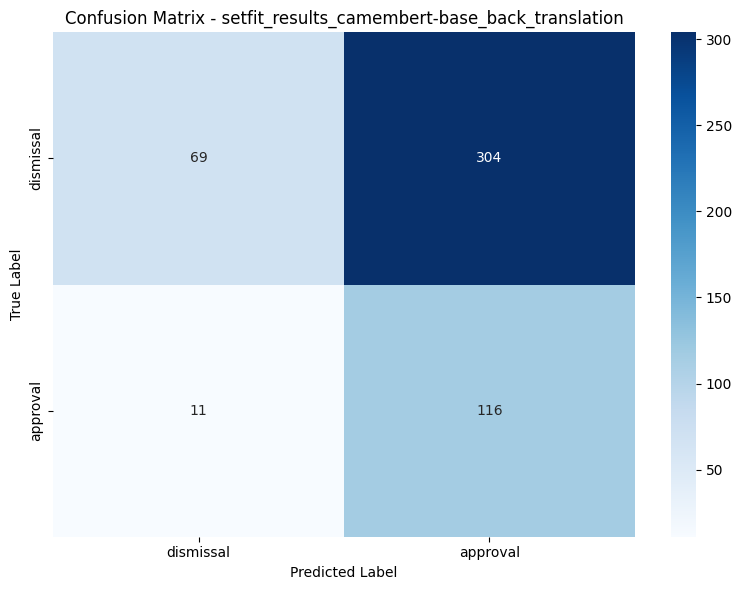

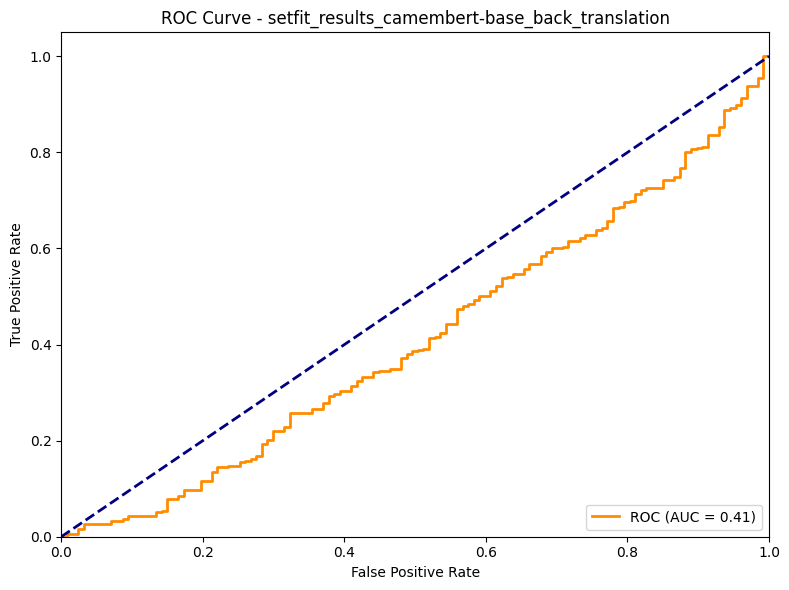

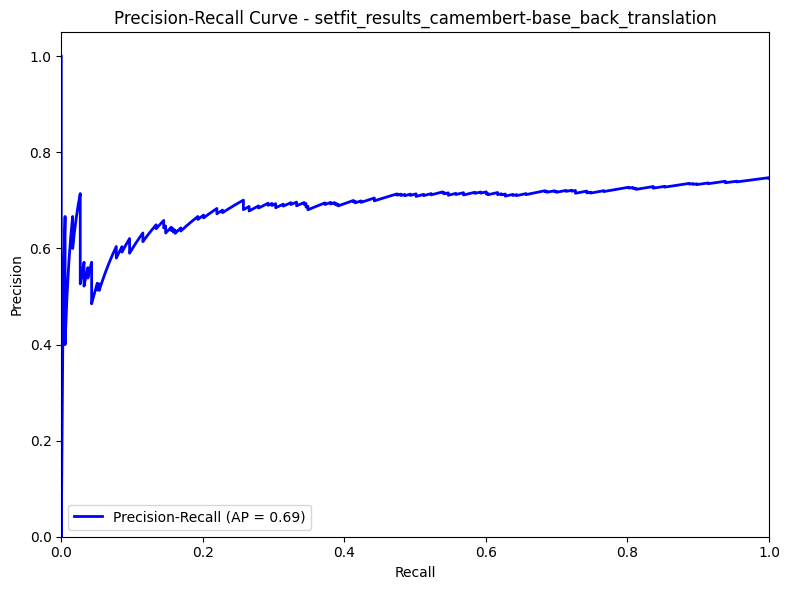

In [13]:
model_name = 'camembert-base'
augmentation_technique_name = 'back_translation'

# Evaluate CamemBERT model
if 'labels' in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with SetFit

model_path = os.path.join('models', 'part_2', 'b', f'setfit_best_{model_name}_{augmentation_technique_name}')

y_test_true, y_test_pred_labels, y_test_pred_probas = evaluate_setfit_on_test(
    model_path=model_path, 
    test_df=test_df_fr, 
    sample_size=500,  # Sample size for the test set (optional, can be adjusted)
    seed=seed
)

# Convert integer labels to string labels for better readability
y_test_true_str = [labels_map[label] for label in y_test_true]
y_test_pred_str = [labels_map[label] for label in y_test_pred_labels]

print("\nFirst 10 true and predicted labels:")
print("True labels:", y_test_true_str[:10])  # Display first 10 true labels
print("Predicted labels:", y_test_pred_str[:10])  # Display first 10 predicted labels
print("Predicted probabilities:", y_test_pred_probas[:10].tolist(), '\n')  # Display first 10 predicted probabilities

# Make evaluation with different metrics
setfit_test_results = evaluate_classification(
    y_true=y_test_true_str,
    y_pred=y_test_pred_str,
    base_filename=f"setfit_results_{model_name}_{augmentation_technique_name}",
    labels=candidate_labels,
    probas=y_test_pred_probas,
    results_dir=os.path.join('results', 'part_2', 'b', 'test')
)

# 3. Zero-Shot Learning with LLM

# 4. Data Generation with LLM

# 5. Optimal Technique Application